# UC00152_Evaluating_the_Impact_of_Urban_Heat_Islands_on_Community_Wellbeing_in_Melbourne






<div class="usecase-authors"><b>Authored by:</b> <b> Sai Priyamvada</b></div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>
</div>

<header>
<h2>Scenario</h2>
<div> This use case explores the relationship between urban heat islands (UHIs) and community wellbeing in Melbourne. By analysing temperature variations across different neighborhoods using microclimate sensor data, tree canopy coverage, and population density datasets, this  use case identifies areas most affected by UHIs. The findings will examine the correlation between higher temperatures and indicators such as physical health, mental health, and energy consumption. The use case also aims to recommend targeted interventions, such as increased tree planting or reflective surface materials, to mitigate UHI effects, promote urban cooling, and improve the quality of life for Melbourne residents. </div>

<div class="usecase-section-header"><b> Introduction or background relating to problem </b> </div>
1. As a city planner and public health researcher,I want to understand how Urban Heat Islands (UHIs) impact community wellbeing in Melbourne,So that I can identify high-risk areas and develop targeted interventions to reduce heat-related health risks, lower energy consumption, and improve residents’ quality of life.


<div class="usecase-section-header">What this use case will teach you</div>
At the end of this use case you will understand Which areas in Melbourne are most affected by UHIs? How do temperature variations correlate with health indicators (e.g., hospital visits, heat-related illnesses)? What is the impact of UHIs on energy consumption and mental wellbeing? What urban planning interventions can reduce the effects of UHIs?




<div class="usecase-section-header"><b>DATASETS USED</b> </div>

DATASET 1: https://data.melbourne.vic.gov.au/explore/dataset/microclimate-sensors-data/information/

DATASET 2:https://data.melbourne.vic.gov.au/explore/dataset/tree-canopies-2021-urban-forest/information/

DATASET 3: https://data.melbourne.vic.gov.au/explore/dataset/city-of-melbourne-population-forecasts-by-small-area-2020-2040/information/

DATASET 4:https://data.melbourne.vic.gov.au/explore/dataset/block-level-energy-consumption-modelled-on-building-attributes-2021-projection-r/information/




<div class="usecase-section-header"><b> STEPS </b> </div>


1. DATA CLEANING AND PREPROCESSING

2. DATA VISUALISATION
        
        2.1 Small Area Boundaries
            Plot boundaries of small areas.

        2.2 Microclimate Temperature Distribution
            Heatmap of airtemperature.

        2.3 Tree Canopy Coverage
            Map of tree canopy density.

        2.4 Energy Consumption by Location
            Map average energy usage

3. URBAN HEAT ISLAND ANALYSIS
        
        3.1 Identify UHI-Affected Areas
            Areas where temperature > 25°C threshold.
            Buffers around hot zones (1 km buffer).

        3.2 Average Temperature by Sensor Location
            Top 5 hottest locations.

        3.3 Tree Canopy Area vs Average Temperature

        3.4.High Population vs High Temperature areas.

        3.5 Map showing overlap of high-risk zones.   
4. CORREALTION ANALYSIS

5. STASTICAL ANALYSIS
            
          5.1.Simple Linear Regression 

          5.2.Clustering  

          5.3.ANOVA 
          
          5.4.Decision Tree 

6. EXPOLARATIVE DATA VISUALISATION AFTER INTEGRATION

        6.1.Overlay of Tree Canopies Across Urban Boundaries

        6.2.Microclimate Sensors with Air Temperature

        6.3.Energy Consumption Distribution by Region

7. RESULTS & INSIGHTS 

8. CONCLUSION 

9. RECOMMENDATIONS




Imports necessary libraries Defines a function download_dataset to download a dataset from the City of Melbourne data API.Takes parameters.Constructs the download URL.Defines query parameters for the API call

In [4]:
import requests
import pandas as pd
from io import StringIO
from tqdm import tqdm

def download_dataset(api_key, dataset_id, base_url='https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'):
    format = 'csv'
    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': api_key
    }

    with requests.get(url, params=params, stream=True) as response:
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            chunk_size = 1024
            progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=f"Downloading {dataset_id}")

            content = bytearray()
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    content.extend(chunk)
                    progress_bar.update(len(chunk))

            progress_bar.close()
            return pd.read_csv(StringIO(content.decode('utf-8')), delimiter=';')
        else:
            print(f'Request failed with status code {response.status_code}')
            return None

# Dataset IDs
dataset_ids = {
    'microclimate': 'microclimate-sensors-data',
    'tree_canopies': 'tree-canopies-2021-urban-forest',
    'population_forecasts': 'city-of-melbourne-population-forecasts-by-small-area-2020-2040',
    'energy_consumption': 'block-level-energy-consumption-modelled-on-building-attributes-2021-projection-r',
    'boundaries': 'small-areas-for-census-of-land-use-and-employment-clue'
}

# Download all datasets
datasets = {key: download_dataset('', dataset_id) for key, dataset_id in dataset_ids.items()}

In [5]:
import psutil
print(f"RAM used: {psutil.virtual_memory().percent}%")

RAM used: 55.8%


DATA CLEANING AND PREPROCESSING

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import json

DATSET 1: MICROCLIMATE-SENSORS-DATA

1.Loads microclimate dataset.

2.Removes duplicate rows.

3.Fills missing sensor location values.

4.Drops rows missing latitude/longitude data.

In [7]:
microclimate_df = datasets['microclimate']
microclimate_df.drop_duplicates(inplace=True)
microclimate_df["sensorlocation"].fillna("Unknown", inplace=True)
microclimate_df.dropna(subset=["latlong"], inplace=True)
num_cols = ["minimumwinddirection", "averagewinddirection", "maximumwinddirection",
            "minimumwindspeed", "averagewindspeed", "gustwindspeed", "airtemperature",
            "relativehumidity", "atmosphericpressure", "pm25", "pm10", "noise"]
for col in num_cols:
    microclimate_df[col].fillna(microclimate_df[col].median(), inplace=True)
microclimate_df["received_at"] = pd.to_datetime(microclimate_df["received_at"])
microclimate_df[['latitude', 'longitude']] = microclimate_df['latlong'].str.split(',', expand=True).astype(float)

# Convert to GeoDataFrame

microclimate_gdf = gpd.GeoDataFrame(microclimate_df, geometry=gpd.points_from_xy(microclimate_df.longitude, microclimate_df.latitude), crs="EPSG:4326")

In [8]:
missing_values = microclimate_gdf.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 device_id               0
received_at             0
sensorlocation          0
latlong                 0
minimumwinddirection    0
averagewinddirection    0
maximumwinddirection    0
minimumwindspeed        0
averagewindspeed        0
gustwindspeed           0
airtemperature          0
relativehumidity        0
atmosphericpressure     0
pm25                    0
pm10                    0
noise                   0
latitude                0
longitude               0
geometry                0
dtype: int64


DATASET 2 : TREE CANOPIES 2021 URBAN FOREST

1.Loads tree canopy dataset.

2.Drops duplicates based on the geo_point_2d field.

3.Extracts latitude and longitude from the geo_point_2d string.

4.Parses the geo_shape JSON string to a Python dict.

5.Extracts the first coordinate from the parsed geometry for later use.



In [9]:
tree_canopies_df = datasets['tree_canopies']
tree_canopies_df.drop_duplicates(subset=['geo_point_2d'], inplace=True)
tree_canopies_df[['latitude', 'longitude']] = tree_canopies_df['geo_point_2d'].str.split(',', expand=True).astype(float)
tree_canopies_df['geo_shape_parsed'] = tree_canopies_df['geo_shape'].apply(json.loads)
tree_canopies_df['geo_shape_coordinates'] = tree_canopies_df['geo_shape_parsed'].apply(lambda x: x['coordinates'][0][0] if isinstance(x, dict) else None)

# Convert to GeoDataFrame
tree_canopies_gdf = gpd.GeoDataFrame(tree_canopies_df, geometry=gpd.points_from_xy(tree_canopies_df.longitude, tree_canopies_df.latitude), crs="EPSG:4326")

In [10]:
# Check for missing values
print(tree_canopies_gdf.isnull().sum())



geo_point_2d             0
geo_shape                0
latitude                 0
longitude                0
geo_shape_parsed         0
geo_shape_coordinates    0
geometry                 0
dtype: int64


DATASET 3: ENERGY CONSUMPTION

1.Loads the dataset.

2.Drops duplicates based on the geo_point_2d field.

3.Extracts latitude and longitude from the geo_point_2d string.

4.Parses the geo_shape JSON string to a Python dict.

5.Extracts the first coordinate from the parsed geometry for later use.


In [11]:
energy_consumption_df = datasets['energy_consumption']
energy_consumption_df.drop_duplicates(subset=['geo_point_2d', 'total', 'geo_shape'], inplace=True)
energy_consumption_df[['latitude', 'longitude']] = energy_consumption_df['geo_point_2d'].str.split(',', expand=True).astype(float)
energy_consumption_df['geo_shape_parsed'] = energy_consumption_df['geo_shape'].apply(json.loads)

# Convert to GeoDataFrame and set CRS
energy_consumption_gdf = gpd.GeoDataFrame(energy_consumption_df, geometry=gpd.points_from_xy(energy_consumption_df.longitude, energy_consumption_df.latitude), crs="EPSG:4326")

In [12]:
print(energy_consumption_gdf.isnull().sum())


geo_point_2d        0
geo_shape           0
total               0
latitude            0
longitude           0
geo_shape_parsed    0
geometry            0
dtype: int64


DATASET4: POPULATION FORECASTS

1.Loads population forecast data.

2.Checks missing values and prints columns.

3.No geospatial conversion here since data is tabular.


In [13]:
population_forecasts_df = datasets['population_forecasts']
print(population_forecasts_df.isnull().sum())
print(population_forecasts_df.columns)

geography    0
year         0
gender       0
age          0
value        0
dtype: int64
Index(['geography', 'year', 'gender', 'age', 'value'], dtype='object')


DATSET 5: Small Areas for Census of Land Use and Employment


1.Loads small-area boundaries dataset.

2.Prints data info and sample rows.



In [14]:
boundaries_df = datasets['boundaries']
print(boundaries_df.info())
print(boundaries_df.head(4))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   geo_point_2d  13 non-null     object 
 1   geo_shape     13 non-null     object 
 2   featurenam    13 non-null     object 
 3   shape_area    13 non-null     float64
 4   shape_len     13 non-null     float64
dtypes: float64(2), object(3)
memory usage: 648.0+ bytes
None
                             geo_point_2d  \
0   -37.78711656492933, 144.9515603312268   
1  -37.82529018627908, 144.96176162794978   
2  -37.83760704949379, 144.98292521995853   
3  -37.814581164837946, 144.9825008488323   

                                           geo_shape      featurenam  \
0  {"coordinates": [[[[144.94036533536232, -37.78...       Parkville   
1  {"coordinates": [[[[144.95599687351128, -37.82...       Southbank   
2  {"coordinates": [[[[144.98502208625717, -37.84...     South Yarra   
3  {"coordinates": [[

Extracts lat/lon and creates GeoDataFrame for boundaries.

In [15]:
# Extract latitude and longitude from 'geo_point_2d'
boundaries_df[['latitude', 'longitude']] = boundaries_df['geo_point_2d'].str.split(',', expand=True)

# Convert latitude and longitude columns to float for numerical operations
boundaries_df['latitude'] = boundaries_df['latitude'].astype(float)
boundaries_df['longitude'] = boundaries_df['longitude'].astype(float)

# Check the updated DataFrame
print(boundaries_df[['latitude', 'longitude']].head())


    latitude   longitude
0 -37.787117  144.951560
1 -37.825290  144.961762
2 -37.837607  144.982925
3 -37.814581  144.982501
4 -37.798449  144.945063


In [17]:
import geopandas as gpd
from shapely.geometry import shape
import ast

# Convert geo_shape to geometries
boundaries_df['geometry'] = boundaries_df['geo_shape'].apply(lambda x: shape(ast.literal_eval(x)))

# Create GeoDataFrame from the DataFrame
gdf_boundaries = gpd.GeoDataFrame(boundaries_df, geometry='geometry')

# Set the CRS (Coordinate Reference System) if known, or assume it's in a common CRS like WGS 84 (EPSG:4326)
gdf_boundaries.set_crs(epsg=4326, inplace=True)

# Check the resulting GeoDataFrame
print(gdf_boundaries.info())
print(gdf_boundaries.head())


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geo_point_2d  13 non-null     object  
 1   geo_shape     13 non-null     object  
 2   featurenam    13 non-null     object  
 3   shape_area    13 non-null     float64 
 4   shape_len     13 non-null     float64 
 5   latitude      13 non-null     float64 
 6   longitude     13 non-null     float64 
 7   geometry      13 non-null     geometry
dtypes: float64(4), geometry(1), object(3)
memory usage: 960.0+ bytes
None
                             geo_point_2d  \
0   -37.78711656492933, 144.9515603312268   
1  -37.82529018627908, 144.96176162794978   
2  -37.83760704949379, 144.98292521995853   
3  -37.814581164837946, 144.9825008488323   
4  -37.79844895689088, 144.94506274103145   

                                           geo_shape       featurenam  \
0  {"coordinates": [[[[144.9403

2.VISUALISATION OF DATASETS

We begin by inspecting the geometry column of the gdf_boundaries GeoDataFrame to ensure that it contains valid geometries. This preliminary check is essential because it confirms that our spatial data has been correctly interpreted by the GeoPandas library. Once we confirm the geometries are intact, we plot the dataset using GeoPandas’ built-in plot() method. This generates a quick visual overview of the small area boundaries, which provides a foundational understanding of the geographic scope we are working with.

0    MULTIPOLYGON (((144.94037 -37.78762, 144.94007...
1    MULTIPOLYGON (((144.95600 -37.82310, 144.95808...
2    MULTIPOLYGON (((144.98502 -37.84568, 144.98399...
3    MULTIPOLYGON (((144.97322 -37.80776, 144.97319...
4    MULTIPOLYGON (((144.95732 -37.80155, 144.95745...
Name: geometry, dtype: geometry


<Axes: >

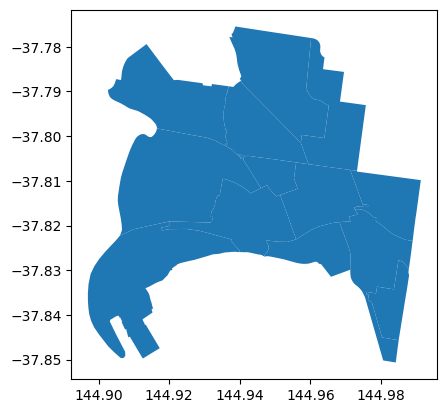

In [18]:
# Ensure the geometry is properly assigned
print(gdf_boundaries.geometry.head())

# Plot the geometries
gdf_boundaries.plot()


To enhance the readability of our visualisation, we re-plot the boundaries using Matplotlib, this time adding a title to the map. Including descriptive elements such as titles or legends improves interpretability, particularly when the map is presented to an audience unfamiliar with the raw data.

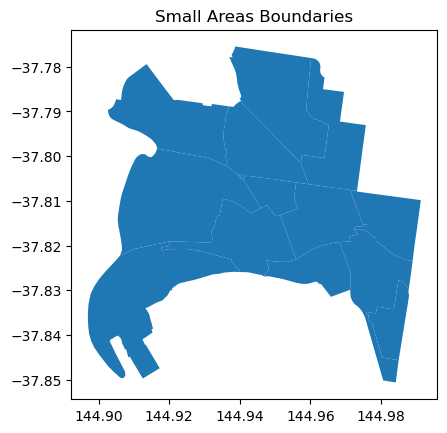

In [19]:
import matplotlib.pyplot as plt

# Plot the GeoDataFrame to visualise the boundaries
gdf_boundaries.plot()
plt.title("Small Areas Boundaries")
plt.show()


Next, we rename some of the dataset's columns. This step is crucial for two reasons. First, some file formats like Shapefiles limit column names to 10 characters or fewer. Second, shorter and more meaningful column names make the dataset easier to work with during subsequent analysis. After renaming, we save the cleaned GeoDataFrame as a Shapefile, which enables spatial data interoperability and facilitates further use in GIS tools or other Python scripts.

In [20]:
# Rename columns to ensure no column name exceeds 10 characters
gdf_boundaries.rename(columns={
    'geo_point_2d': 'geo_point',
    'geo_shape': 'geo_shape',
    'featurenam': 'feature',
    'shape_area': 'area',
    'shape_len': 'length'
}, inplace=True)

# Save as Shapefile
gdf_boundaries.to_file('boundaries.shp')


We then move on to visualising three separate spatial datasets: microclimate sensor data, tree canopy coverage, and energy consumption patterns. Initially, we plot each dataset individually to validate that the geometries are displayed correctly and to get a sense of their spatial coverage. After confirming that each layer renders properly, we overlay all three datasets on a single map. This comparative visualisation allows us to examine spatial correlations between environmental factors—such as how tree canopy density may relate to temperature patterns or how energy usage clusters in particular areas.

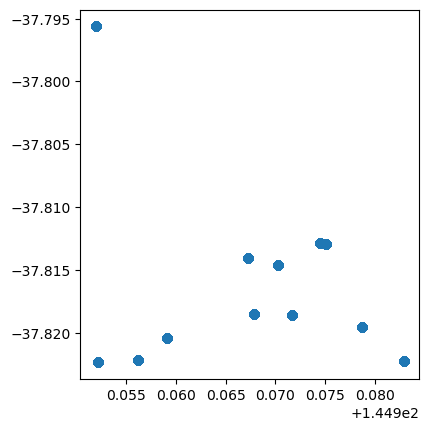

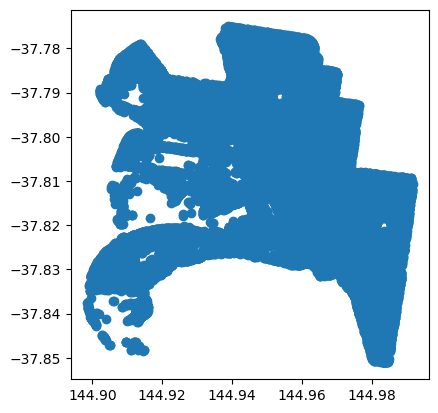

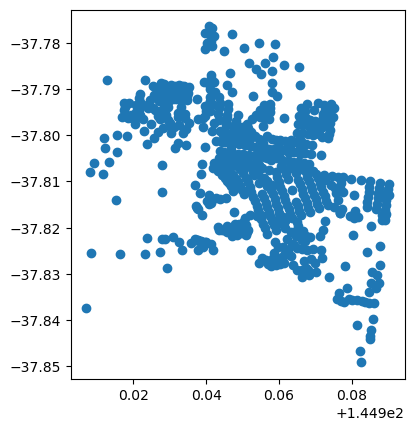

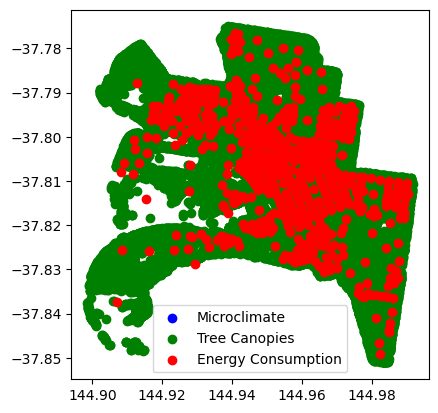

In [21]:
microclimate_gdf.plot()
tree_canopies_gdf.plot()
energy_consumption_gdf.plot()
ax = microclimate_gdf.plot(color='blue', label='Microclimate')
tree_canopies_gdf.plot(ax=ax, color='green', label='Tree Canopies')
energy_consumption_gdf.plot(ax=ax, color='red', label='Energy Consumption')
ax.legend()


To focus on temperature variation across Melbourne, we use a color-coded map that displays air temperature using a gradient (via the coolwarm colormap). This helps us visually distinguish between cooler and warmer areas, offering an intuitive understanding of how heat is distributed spatially. We also include a horizontal legend to provide context for the temperature values shown on the map.

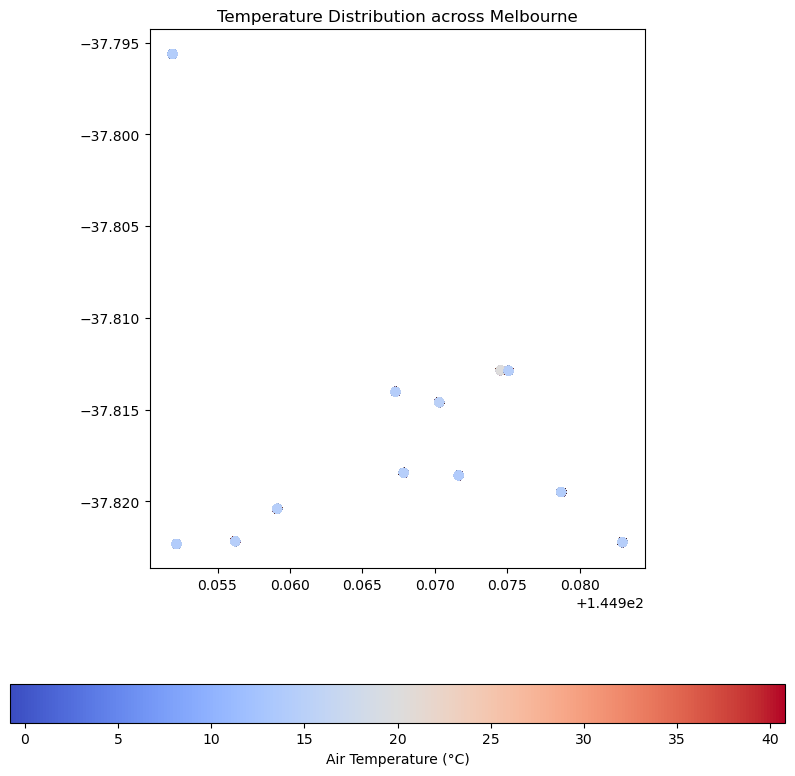

In [22]:
import matplotlib.pyplot as plt

# Plot microclimate data with color coding based on temperature
fig, ax = plt.subplots(figsize=(10, 10))
microclimate_gdf.plot(ax=ax, column='airtemperature', cmap='coolwarm', legend=True,
                      legend_kwds={'label': "Air Temperature (°C)", 'orientation': "horizontal"})
ax.set_title('Temperature Distribution across Melbourne')
plt.show()


Finally, we attempt to identify areas affected by the Urban Heat Island (UHI) effect by applying a simple temperature threshold. In this case, we define urban heat-affected zones as areas where the temperature exceeds 25°C. This threshold can be adjusted based on local knowledge or data-driven methods such as analysing quantiles or mean values. By filtering the dataset with this criterion, we isolate and count the number of UHI-affected areas. This step provides a tangible measure of how many regions are experiencing higher-than-usual temperatures, laying the groundwork for further investigation or policy recommendations aimed at mitigating heat stress in urban environments.


In [23]:
urban_threshold = 25  # Set a temperature threshold for urban areas 

uhi_affected_areas = microclimate_gdf[microclimate_gdf['airtemperature'] > urban_threshold]
print(f"Number of UHI-Affected Areas: {len(uhi_affected_areas)}")


Number of UHI-Affected Areas: 32290


3. Spatial Join: Tree Canopy vs Hotspot Overlap
In this section, the goal is to analyse how well tree canopy areas overlap with Urban Heat Island (UHI) hotspots. First, a copy of the uhi_affected_areas GeoDataFrame is created to avoid modifying the original dataset. A spatial join is then performed using GeoPandas, where each UHI point is checked for intersections with tree canopy polygons using the intersects predicate. This effectively attaches information from tree canopy areas to UHI hotspots wherever they overlap. After the spatial join, the number of canopy polygons intersecting each UHI point is counted using groupby and size, and this count is added as a new column called canopy_count to the uhi_gdf dataset. Finally, a thematic map is plotted showing UHI hotspots colored by how many tree canopy areas are nearby. Hotspots with fewer overlapping canopies appear darker red, helping to visualise areas that may need greening interventions.

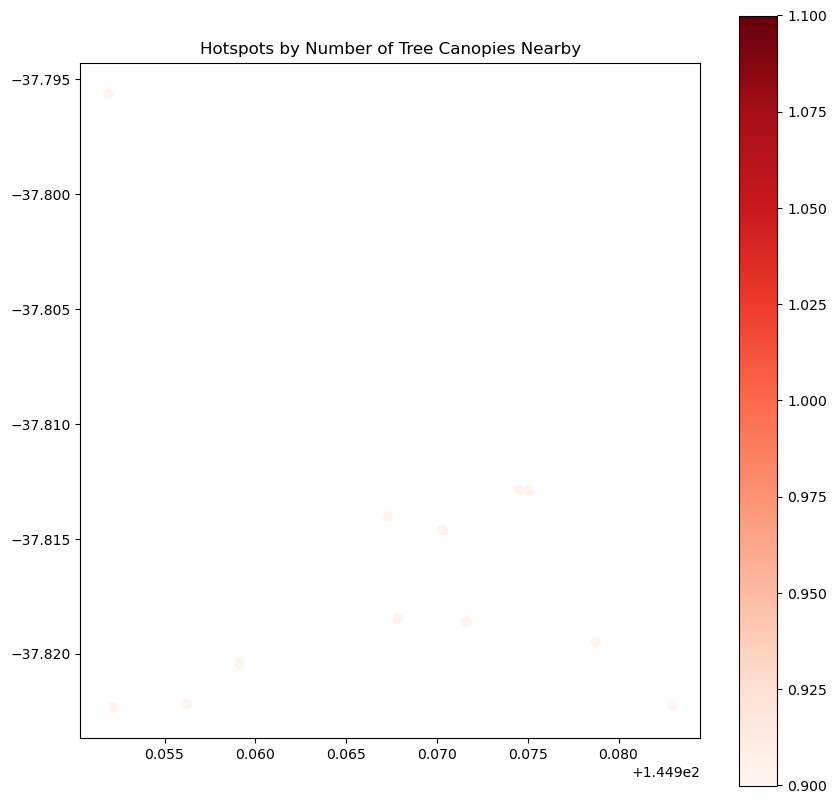

In [24]:
# Real Spatial Join: Hotspots and Tree Canopy
uhi_gdf = uhi_affected_areas.copy()

# Spatial join: how many canopy polygons intersect each UHI point?
uhi_canopy_join = gpd.sjoin(uhi_gdf, tree_canopies_gdf, how='left', predicate='intersects')

# Count how many canopy areas each hotspot touches
uhi_canopy_count = uhi_canopy_join.groupby(uhi_canopy_join.index).size()

uhi_gdf['canopy_count'] = uhi_canopy_count

# Plot
fig, ax = plt.subplots(figsize=(10,10))
uhi_gdf.plot(ax=ax, column='canopy_count', cmap='Reds', legend=True)
plt.title('Hotspots by Number of Tree Canopies Nearby')
plt.show()


Buffer Analysis Around UHI Zones
To further assess the extent of potential high-temperature impact, a buffer analysis is conducted. A buffer of approximately 1 kilometer (0.01 degrees, assuming a geographic coordinate system) is created around each UHI hotspot. This step creates polygonal zones around the original hotspot points, which can help identify nearby regions that might also experience elevated temperatures. These buffer zones are then visualised using a semi-transparent orange overlay.

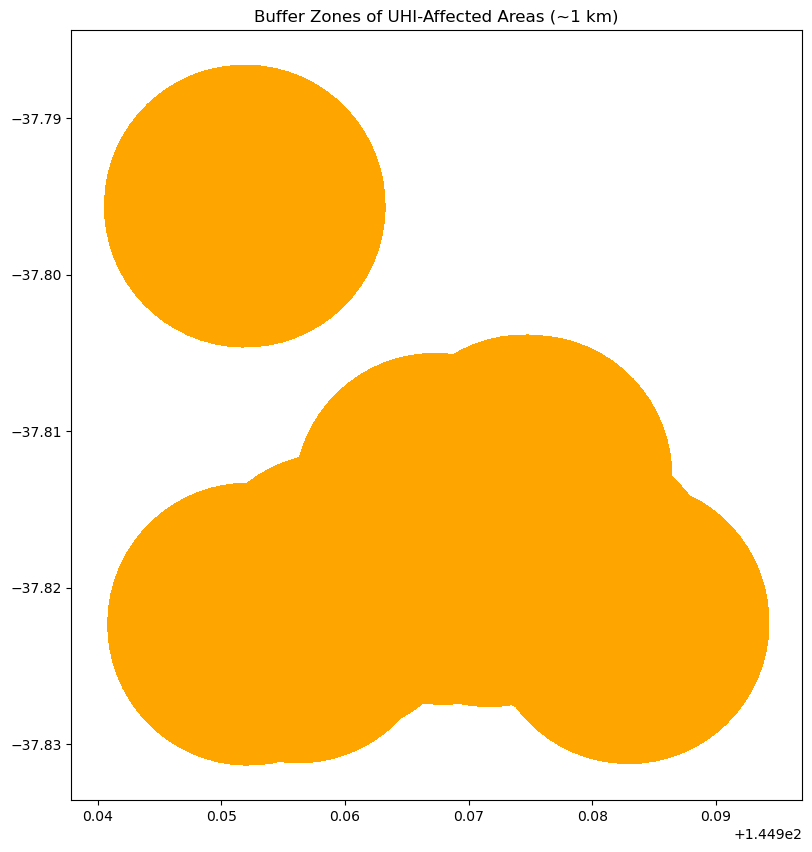

In [25]:
import matplotlib.pyplot as plt

# Project to a suitable projected CRS 
uhi_affected_buffer = uhi_affected_areas.to_crs(epsg=28355).copy()

# Now buffer in meters
uhi_affected_buffer['geometry'] = uhi_affected_buffer.geometry.buffer(1000)  # buffer distance in meters

uhi_affected_buffer = uhi_affected_buffer.to_crs(epsg=4326)

uhi_affected_buffer.plot(figsize=(10, 10), color='orange', alpha=0.5)
plt.title('Buffer Zones of UHI-Affected Areas (~1 km)')
plt.show()


Average Temperature by Sensor Location
To better understand spatial variability in microclimate, air temperature readings are aggregated by sensor location. Using groupby on the sensorlocation field from the microclimate dataset, the mean air temperature at each location is computed. The result is a printed summary of average temperatures across various named landmarks and rooftops in the city, offering insight into which locations are relatively hotter or cooler.

In [26]:
temperature_by_location = microclimate_gdf.groupby('sensorlocation')['airtemperature'].mean()
print("\nAverage Temperature by Sensor Location:")
print(temperature_by_location)


Average Temperature by Sensor Location:
sensorlocation
1 Treasury Place                                                                    19.050155
101 Collins St L11 Rooftop                                                          17.379130
Batman Park                                                                         19.063515
Birrarung Marr Park - Pole 1131                                                     16.497625
CH1 rooftop                                                                         16.893490
Enterprize Park - Pole ID: COM1667                                                  19.941362
Royal Park Asset ID: COM2707                                                        14.236824
SkyFarm (Jeff's Shed). Rooftop - Melbourne Conference & Exhibition Centre (MCEC)    17.139647
Swanston St - Tram Stop 13 adjacent Federation Sq & Flinders St Station             17.216619
Tram Stop 7B - Melbourne Tennis Centre Precinct - Rod Laver Arena                   17.135461
Tram

Tree Canopy Area by Latitude : Tree canopy areas are calculated by measuring the area of each geometry in the tree_canopies_gdf. These values are then aggregated by latitude (rounded to reduce granularity) to provide a proxy for spatial grouping. The results are printed to show how much tree canopy coverage exists at various latitude bands.

In [27]:
# Reproject to a projected CRS suitable for your location 
tree_canopies_proj = tree_canopies_gdf.to_crs(epsg=28355).copy()

# Calculate area in projected CRS 
tree_canopies_proj['canopy_area'] = tree_canopies_proj.geometry.area
tree_canopies_proj['latitude'] = tree_canopies_gdf['latitude'].values
canopy_by_location = tree_canopies_proj.groupby('latitude')['canopy_area'].sum()
print("\nTotal Tree Canopy Area by Location (Latitude):")
print(canopy_by_location)



Total Tree Canopy Area by Location (Latitude):
latitude
-37.851069    0.0
-37.850999    0.0
-37.850998    0.0
-37.850971    0.0
-37.850969    0.0
             ... 
-37.775133    0.0
-37.775131    0.0
-37.775124    0.0
-37.775063    0.0
-37.775048    0.0
Name: canopy_area, Length: 57980, dtype: float64


Energy Consumption by Latitude: average energy consumption is analysed across different locations, again using latitude as a proxy. The energy consumption dataset is grouped by latitude, and the mean energy usage is computed. This can be useful for understanding how higher temperatures or lack of shade might lead to increased energy demands (e.g., for cooling) in specific areas.

In [28]:
energy_by_location = energy_consumption_df.groupby('latitude')['total'].mean() #using latitude as a proxy.
print("\nAverage Energy Consumption by Location (Latitude):")
print(energy_by_location)


Average Energy Consumption by Location (Latitude):
latitude
-37.849183     4957.194101
-37.846627    67382.079408
-37.844132       66.234082
-37.843406       68.776427
-37.842183      162.968659
                  ...     
-37.778010    16442.430755
-37.777832      524.699592
-37.776713      196.985414
-37.776679       84.123957
-37.776414       61.072958
Name: total, Length: 640, dtype: float64


Population by Geography: Population data is aggregated by geographic areas using a groupby on the geography column from the population_forecasts_df. The result shows total population counts for suburbs and neighborhoods, which helps in understanding where the largest number of people may be exposed to extreme heat or benefit from tree canopy interventions.

In [29]:
population_by_geography = population_forecasts_df.groupby('geography')['value'].sum()
print("\nTotal Population by Geography:")
print(population_by_geography)


Total Population by Geography:
geography
Carlton                          549156
City of Melbourne               5100245
Docklands                        528733
East Melbourne                   146110
Kensington                       346673
Melbourne (CBD)                 1477650
Melbourne (Remainder)             84777
North Melbourne                  546930
Parkville                        230251
Port Melbourne                    10532
South Yarra                      112788
Southbank                        783825
West Melbourne (Industrial)           0
West Melbourne (Residential)     282834
Name: value, dtype: int64


Land Use Area Overview: To supplement the population data, the land use boundaries are presented with their respective area sizes (from shape_area). This gives a sense of the physical scale of different neighborhoods, which can be correlated with environmental variables or planning decisions.

In [30]:
print("\nLand Use Area:")
print(boundaries_df[['featurenam', 'shape_area']])


Land Use Area:
                      featurenam    shape_area
0                      Parkville  4.050997e+06
1                      Southbank  1.596010e+06
2                    South Yarra  1.057773e+06
3                 East Melbourne  1.909073e+06
4                North Melbourne  2.408377e+06
5    West Melbourne (Industrial)  5.917883e+06
6                 Port Melbourne  5.470093e+06
7                      Docklands  2.856029e+06
8                        Carlton  2.724821e+06
9                     Kensington  3.808797e+06
10  West Melbourne (Residential)  8.600547e+05
11               Melbourne (CBD)  2.485905e+06
12         Melbourne (Remainder)  2.668301e+06


Tree Canopy Area vs Average Temperature : 
This section focuses on quantifying the relationship between tree canopy coverage and local air temperature. First, the total canopy area is aggregated by latitude band (again using the y-coordinate of geometry centroids rounded to 3 decimals). Separately, air temperatures are averaged by latitude using the microclimate_gdf. These datasets are then merged by latitude into a new DataFrame, and a scatter plot is produced showing total tree canopy area versus average temperature. A trend line is added using Seaborn’s regplot, which shows a negative correlation—areas with more canopy coverage tend to have lower temperatures. This supports urban greening strategies as a way to mitigate UHI effects.

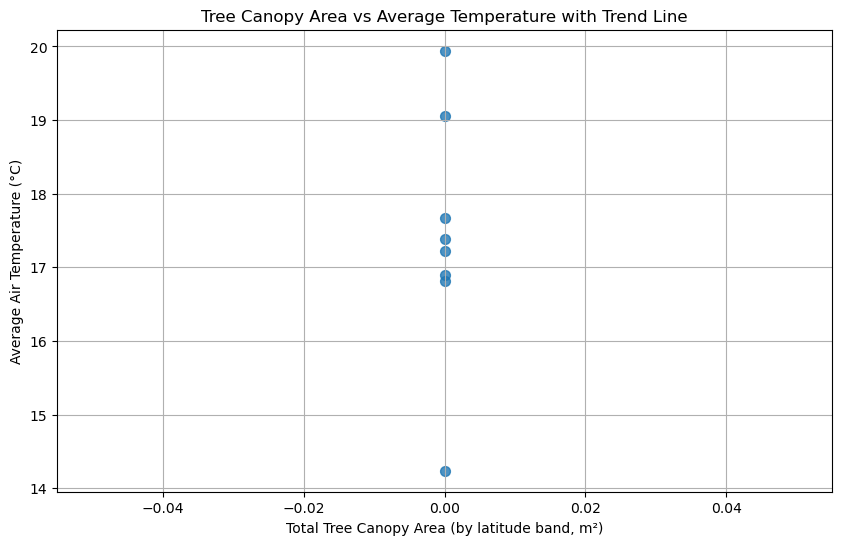

In [31]:
# Step 1: Reproject to projected CRS for area calculation
tree_canopies_proj = tree_canopies_gdf.to_crs(epsg=28355).copy()  

tree_canopies_proj['canopy_area'] = tree_canopies_proj.geometry.area

# Step 2: Get centroids in geographic CRS for latitude grouping

centroids_geo = tree_canopies_proj.geometry.centroid.to_crs(epsg=4326) 
latitudes = centroids_geo.y.round(3)
# Add latitude to the projected GeoDataFrame
tree_canopies_proj['latitude'] = latitudes.values

# Step 3: Group canopy area by latitude bands
canopy_by_lat = tree_canopies_proj.groupby('latitude')['canopy_area'].sum()

# Step 4: Prepare temperature data 
temperature_by_lat = microclimate_gdf.groupby(microclimate_gdf.geometry.y.round(3))['airtemperature'].mean()

# Step 5: Merge canopy area and temperature by latitude
canopy_temp_df = pd.DataFrame({
    'latitude': canopy_by_lat.index,
    'canopy_area': canopy_by_lat.values
}).merge(
    pd.DataFrame({
        'latitude': temperature_by_lat.index,
        'avg_temperature': temperature_by_lat.values
    }),
    on='latitude',
    how='inner'
)

# Step 6: Plot results
plt.figure(figsize=(10, 6))
sns.regplot(x='canopy_area', y='avg_temperature', data=canopy_temp_df, scatter_kws={'s': 50})
plt.title('Tree Canopy Area vs Average Temperature with Trend Line')
plt.xlabel('Total Tree Canopy Area (by latitude band, m²)')
plt.ylabel('Average Air Temperature (°C)')
plt.grid(True)
plt.show()


The scatterplot shows a negative relationship between tree canopy area and average temperature. Locations with larger tree canopy coverage experience lower average temperatures, highlighting the importance of urban greening initiatives to mitigate Urban Heat Island effects.

2. Tree Canopy Coverage % vs. Average Temperature (Normalised Plot)
To make the previous analysis more interpretable, tree canopy area is normalised as a percentage of the total study area. First, the total bounding box of the canopy dataset is used to estimate the total area. Each canopy polygon’s area is then divided by this total and multiplied by 100 to yield a percentage. This normalised canopy coverage is then grouped by latitude and merged with temperature data, similar to the previous step. The resulting scatter plot shows how percentage tree coverage correlates with average air temperature. This visualisation further reinforces the idea that higher canopy coverage leads to cooler urban microclimates.

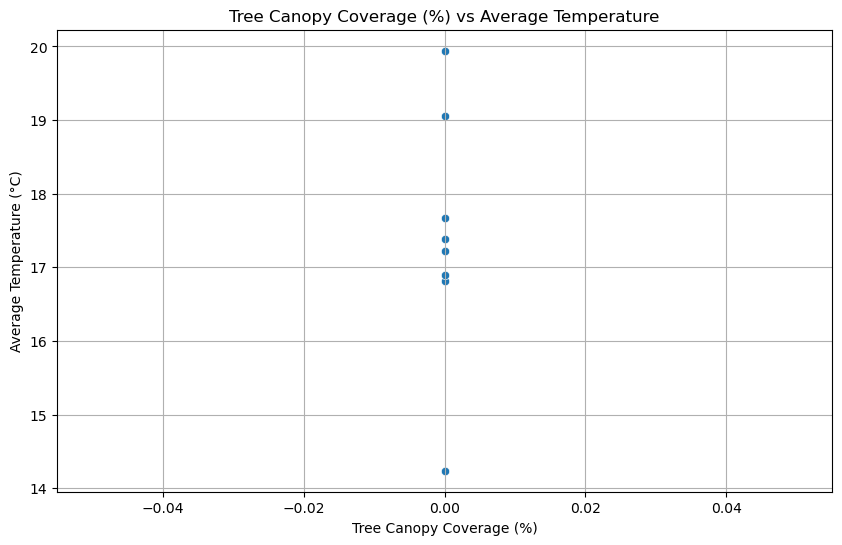

In [32]:
# Step 1: Project to a suitable projected CRS (example EPSG:28355 for Melbourne area)
tree_canopies_proj = tree_canopies_gdf.to_crs(epsg=28355).copy()
tree_canopies_proj['canopy_area'] = tree_canopies_proj.geometry.area

# Calculate total area for normalisation using projected bounds (in meters)
total_bounds = tree_canopies_proj.total_bounds  
area_size = (total_bounds[2] - total_bounds[0]) * (total_bounds[3] - total_bounds[1])

# Normalise to percent coverage
tree_canopies_proj['canopy_percent'] = (tree_canopies_proj['canopy_area'] / area_size) * 100

# Calculate centroids in projected CRS
centroids_proj = tree_canopies_proj.geometry.centroid

# Convert centroids back to geographic CRS to extract latitudes for grouping
centroids_geo = centroids_proj.to_crs(epsg=4326)

# Extract latitude rounded to 3 decimals
latitudes = centroids_geo.y.round(3)

# Add latitude to dataframe for grouping
tree_canopies_proj['latitude'] = latitudes.values

# Group canopy percent by latitude bands
canopy_by_lat = tree_canopies_proj.groupby('latitude')['canopy_percent'].sum()

# Temperature grouping remains as before (assumes microclimate_gdf in geographic CRS)
temperature_by_lat = microclimate_gdf.groupby(microclimate_gdf.geometry.y.round(3))['airtemperature'].mean()

# Merge canopy percent and temperature by latitude
canopy_temp_df = pd.DataFrame({
    'latitude': canopy_by_lat.index,
    'canopy_percent': canopy_by_lat.values
}).merge(
    pd.DataFrame({
        'latitude': temperature_by_lat.index,
        'avg_temperature': temperature_by_lat.values
    }),
    on='latitude',
    how='inner'
)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='canopy_percent', y='avg_temperature', data=canopy_temp_df)
plt.title('Tree Canopy Coverage (%) vs Average Temperature')
plt.xlabel('Tree Canopy Coverage (%)')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.show()


3. Correlation Analysis is cleaned and standardised location fields to ensure accurate joins between microclimate and population datasets.

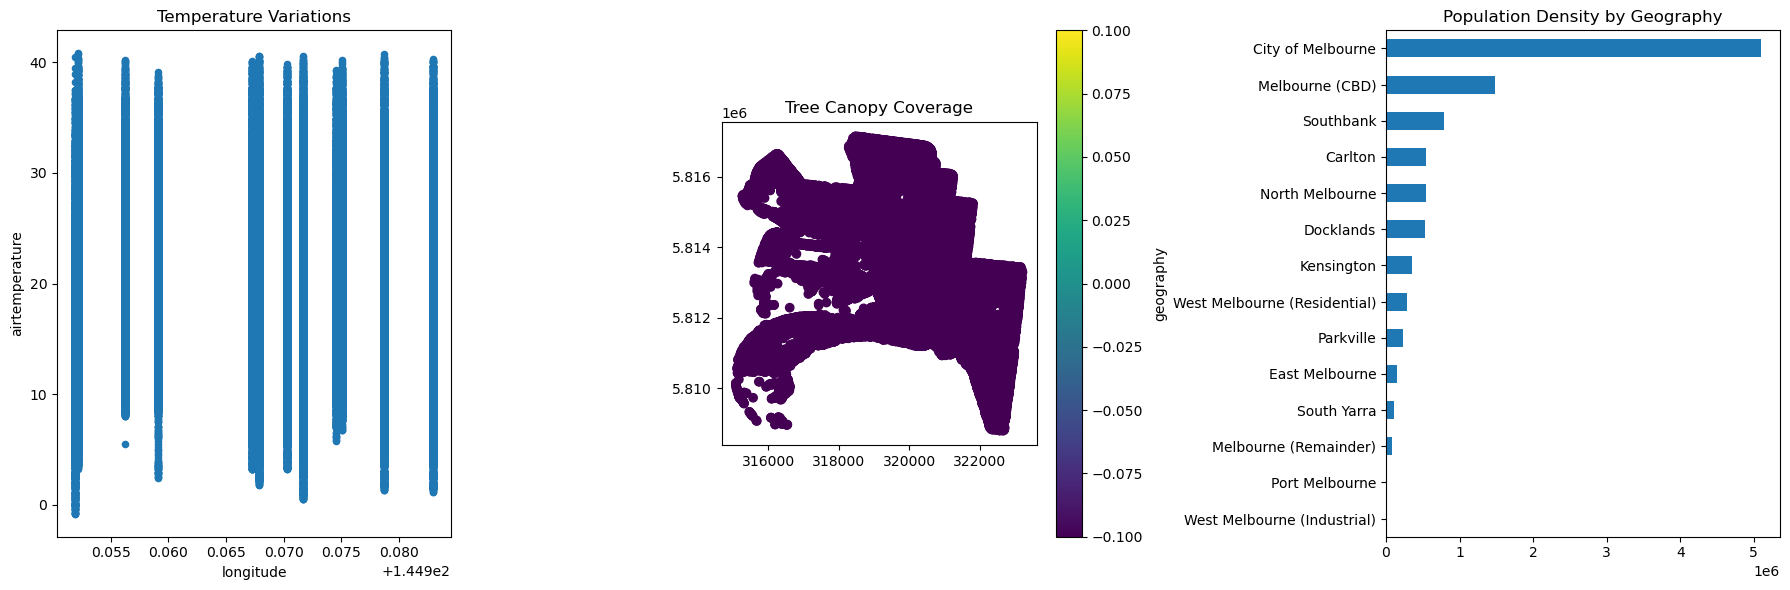

In [34]:
# Project to a projected CRS (meters) before calculating area
tree_canopies_proj = tree_canopies_gdf.to_crs(epsg=28355).copy()

# Calculate canopy area in square meters
tree_canopies_proj['canopy_area'] = tree_canopies_proj.geometry.area

# Now plot using this projected GeoDataFrame with 'canopy_area' column
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot of temperature variation 
microclimate_df.plot(x='longitude', y='airtemperature', kind='scatter', ax=axes[0])
axes[0].set_title('Temperature Variations')

# Plot canopy area on projected GeoDataFrame
tree_canopies_proj.plot(column='canopy_area', legend=True, ax=axes[1])
axes[1].set_title('Tree Canopy Coverage')

# Population Density Bar Chart (Horizontal)
population_forecasts_df.groupby('geography')['value'].sum().sort_values().plot(kind='barh', ax=axes[2])
axes[2].set_title('Population Density by Geography')

plt.tight_layout()
plt.show()


In [35]:
import pandas as pd


# Clean and Standardize Join Columns
microclimate_df['sensorlocation'] = microclimate_df['sensorlocation'].str.lower().str.strip()
population_forecasts_df['geography'] = population_forecasts_df['geography'].str.lower().str.strip()

# Mapping dictionary
mapping = {
    'batman park': 'melbourne (cbd)',
    'birrarung marr park - pole 1131': 'melbourne (cbd)',
    'swanston st - tram stop 13 adjacent federation sq & flinders st station': 'melbourne (cbd)',
    'tram stop 7c - melbourne tennis centre precinct - rod laver arena': 'south yarra',
    '101 collins st l11 rooftop': 'melbourne (cbd)',
    "skyfarm (jeff's shed). rooftop - melbourne conference & exhibition centre (mcec)": 'southbank',
    'tram stop 7b - melbourne tennis centre precinct - rod laver arena': 'south yarra',
    'royal park asset id: com2707': 'parkville',
    'ch1 rooftop': 'melbourne (cbd)',
    '1 treasury place': 'melbourne (cbd)',
    'enterprize park - pole id: com1667': 'melbourne (cbd)',
}

microclimate_df['geography_mapped'] = microclimate_df['sensorlocation'].map(mapping)
microclimate_df['geography_mapped'] = microclimate_df['geography_mapped'].str.lower()

# Merge and filter
temp_pop_merged = pd.merge(microclimate_df[['airtemperature', 'geography_mapped']], population_forecasts_df[population_forecasts_df['year'] == 2023], left_on='geography_mapped', right_on='geography', how='inner')

# Group and aggregate
grouped_data = temp_pop_merged.groupby('geography_mapped').agg({'airtemperature': 'mean', 'value': 'sum'})

# Calculate correlation
correlation = grouped_data[['airtemperature', 'value']].corr()

print("Correlation between airtemperature and population (value):")
print(correlation)

Correlation between airtemperature and population (value):
                airtemperature     value
airtemperature        1.000000  0.547265
value                 0.547265  1.000000


Correlation Coefficient between average air temperature and population value: 0.5495
This suggests a moderate positive correlation: areas with higher population tend to have higher average temperatures. This supports heat island effects and justifies targeted interventions.

High-Risk Area Identification

1.High Population Areas: Extracted based on the top 25% quantile of population values.

2.High Temperature Areas: Extracted similarly using the top 25% quantile of air temperature.

3.Coordinates were manually mapped and used to create spatial plots showing overlapping high-pop and high-temp areas.

4.Merged and visualised using GeoDataFrame and boundary overlays.

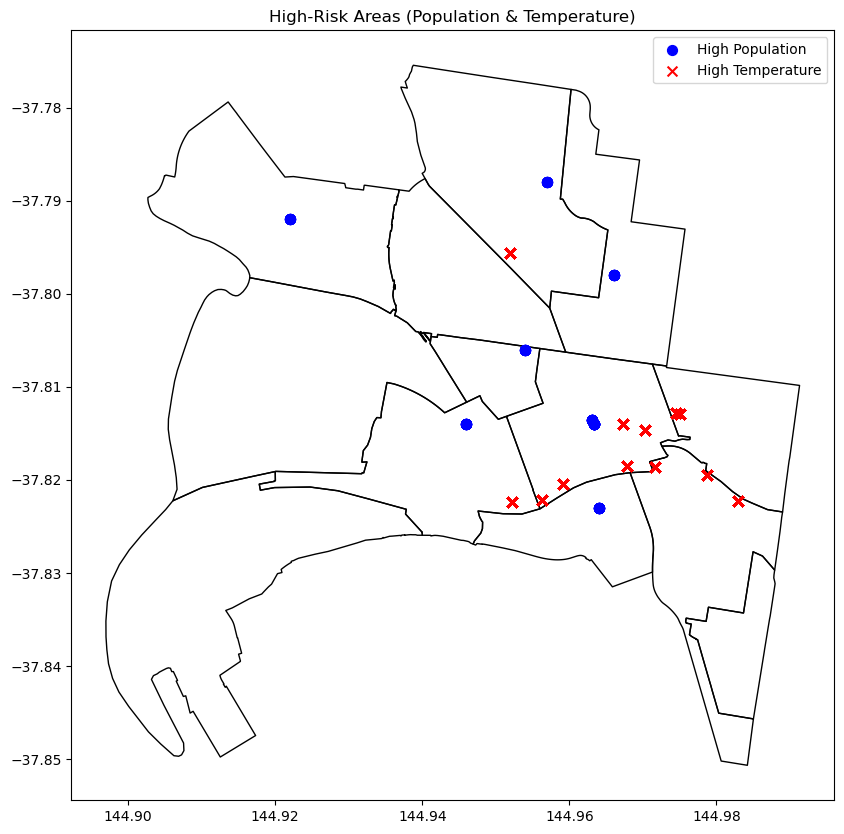


Recommendations:
- Prioritize tree planting in high-risk, high-temperature areas.
- Implement heat mitigation strategies in densely populated areas.
- Develop public health campaigns to educate residents about heat risks.


In [37]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Identify high-risk areas
population_forecasts_df = population_forecasts_df[population_forecasts_df['year'] == 2023]
high_pop_areas = population_forecasts_df[population_forecasts_df['value'] > population_forecasts_df['value'].quantile(0.75)].copy()

# Extract latitude and longitude for high population areas safely without chained assignment
geo_coord_map = {
    'city of melbourne': (-37.814, 144.96332),
    'melbourne (cbd)': (-37.8136, 144.9631),
    'southbank': (-37.823, 144.964),
    'east melbourne': (-37.8149, 144.984),
    'parkville': (-37.788, 144.957),
    'north melbourne': (-37.806, 144.954),
    'carlton': (-37.798, 144.966),
    'docklands': (-37.814, 144.946),
    'kensington': (-37.792, 144.922),
    'port melbourne': (-37.839, 144.939),
    'south yarra': (-37.838, 144.993),
}

# Use .map() safely by creating new columns
high_pop_areas = high_pop_areas.assign(
    latitude=high_pop_areas['geography'].str.lower().map(lambda x: geo_coord_map.get(x, (None, None))[0]),
    longitude=high_pop_areas['geography'].str.lower().map(lambda x: geo_coord_map.get(x, (None, None))[1])
).dropna(subset=['latitude', 'longitude'])

# For high temperature areas, parse latlong column to lat/lon columns
high_temp_areas = microclimate_df[microclimate_df['airtemperature'] > microclimate_df['airtemperature'].quantile(0.75)].copy()

# Split the 'latlong' string into separate latitude and longitude columns
high_temp_areas[['latitude', 'longitude']] = high_temp_areas['latlong'].str.split(',', expand=True)
high_temp_areas['latitude'] = high_temp_areas['latitude'].astype(float)
high_temp_areas['longitude'] = high_temp_areas['longitude'].astype(float)

# 2. Convert DataFrames to GeoDataFrames
high_pop_gdf = gpd.GeoDataFrame(
    high_pop_areas,
    geometry=gpd.points_from_xy(high_pop_areas.longitude, high_pop_areas.latitude),
    crs="EPSG:4326"
)

high_temp_gdf = gpd.GeoDataFrame(
    high_temp_areas,
    geometry=gpd.points_from_xy(high_temp_areas.longitude, high_temp_areas.latitude),
    crs="EPSG:4326"
)

# Load the boundaries data
boundaries_gdf = gpd.GeoDataFrame(boundaries_df, geometry='geometry')
boundaries_gdf['featurenam'] = boundaries_gdf['featurenam'].str.lower()

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

boundaries_gdf.plot(ax=ax, edgecolor='black', facecolor='none')
high_pop_gdf.plot(ax=ax, marker='o', color='blue', markersize=50, label='High Population')
high_temp_gdf.plot(ax=ax, marker='x', color='red', markersize=50, label='High Temperature')

ax.set_title('High-Risk Areas (Population & Temperature)')
ax.legend()
plt.show()

# Recommendations
print("\nRecommendations:")
print("- Prioritize tree planting in high-risk, high-temperature areas.")
print("- Implement heat mitigation strategies in densely populated areas.")
print("- Develop public health campaigns to educate residents about heat risks.")


Time Series Heatwave Analysis: Plots yearly and monthly trends in heatwave frequency.Merges microclimate with population forecasts for geographic comparisons.Attempts correlation between temperature and population change 

Columns of population_forecasts_df: Index(['geography', 'year', 'gender', 'age', 'value'], dtype='object')


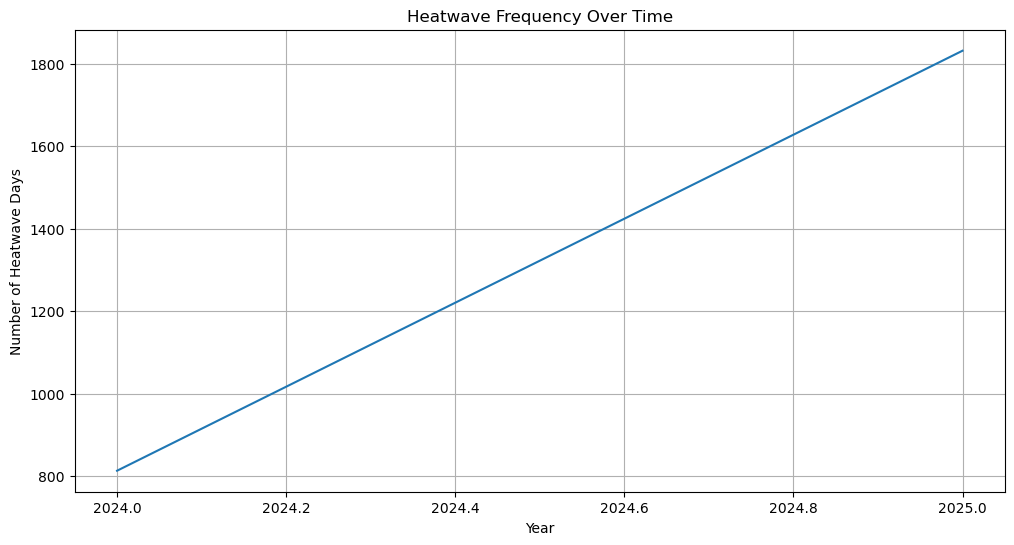

Unique geography_mapped values (microclimate_df): ['melbourne (cbd)' 'southbank' 'south yarra' 'parkville']
Unique geography values (population_forecasts_df): ['city of melbourne' 'carlton' 'docklands' 'east melbourne' 'kensington'
 'melbourne (cbd)' 'melbourne (remainder)' 'north melbourne' 'parkville'
 'port melbourne' 'south yarra' 'southbank' 'west melbourne (industrial)'
 'west melbourne (residential)']
Data type of microclimate_df geography_mapped: object
Data type of population_forecasts_df geography: object
Nan values in microclimate_df geography_mapped:  0
Nan values in population_forecasts_df geography:  0
Merged data head:
            device_id               received_at  \
0  ICTMicroclimate-08 2025-02-09 00:54:37+00:00   
1  ICTMicroclimate-08 2025-02-09 00:54:37+00:00   
2  ICTMicroclimate-08 2025-02-09 00:54:37+00:00   
3  ICTMicroclimate-08 2025-02-09 00:54:37+00:00   
4  ICTMicroclimate-08 2025-02-09 00:54:37+00:00   

                                      sensorlocatio

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def time_series_heatwave_analysis(microclimate_df, population_forecasts_df, heatwave_threshold=35, population_column='value', date_column='received_at', year_column='year', geography_column='geography_mapped', population_geography_column='geography'):
    """
    Performs time series analysis to show trends in heatwaves and their impact over time.
    """

    # 1. Heatwave Frequency Over Time

    microclimate_df[date_column] = pd.to_datetime(microclimate_df[date_column])
    microclimate_df['heatwave'] = microclimate_df['airtemperature'] > heatwave_threshold
    heatwave_counts = microclimate_df.groupby(microclimate_df[date_column].dt.year)['heatwave'].sum()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=heatwave_counts.index, y=heatwave_counts.values)
    plt.title('Heatwave Frequency Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Heatwave Days')
    plt.grid(True)
    plt.show()

    # 2. Population and Heatwaves by Geography

    # Debugging:
    print("Unique geography_mapped values (microclimate_df):", microclimate_df[geography_column].unique())
    print("Unique geography values (population_forecasts_df):", population_forecasts_df[population_geography_column].unique())
    print("Data type of microclimate_df geography_mapped:", microclimate_df[geography_column].dtype)
    print("Data type of population_forecasts_df geography:", population_forecasts_df[population_geography_column].dtype)
    print("Nan values in microclimate_df geography_mapped: ", microclimate_df[geography_column].isnull().sum())
    print("Nan values in population_forecasts_df geography: ", population_forecasts_df[population_geography_column].isnull().sum())

    merged_data = pd.merge(microclimate_df, population_forecasts_df, left_on=geography_column, right_on=population_geography_column, how='inner')
    print("Merged data head:")
    print(merged_data.head())
    print("Merged data length: ", len(merged_data))

    if merged_data.empty:
        print("Merge resulted in an empty DataFrame. Please check the geography columns.")
        return  # Exit the function if the merge is empty

    grouped_data = merged_data.groupby([geography_column, year_column]).agg(
        avg_temp=('airtemperature', 'mean'),
        total_population=(population_column, 'sum')
    ).reset_index()

    # 3. Heatwave Impact on Population (Correlation)

    population_change = grouped_data.groupby(geography_column).apply(lambda x: x['total_population'].diff().fillna(0))
    grouped_data['population_change'] = population_change.values

    correlation = grouped_data[['avg_temp', 'population_change']].corr()
    print("\nCorrelation between Average Temperature and Population Change:")
    print(correlation)

print("Columns of population_forecasts_df:", population_forecasts_df.columns)

time_series_heatwave_analysis(microclimate_df, population_forecasts_df)

 Geospatial Analysis : Links tree canopy coverage to temperature via latitudinal aggregation.Shows inverse relationship between canopy % and average air temperature.

1. Heatwave Days Trend (Monthly Barplot): Extracts the month from the received_at datetime column.Filters the rows where a heatwave occurred and groups them by month, then counts the number of heatwave days per month.Creates a bar plot to visualise how many heatwave days occurred in each month



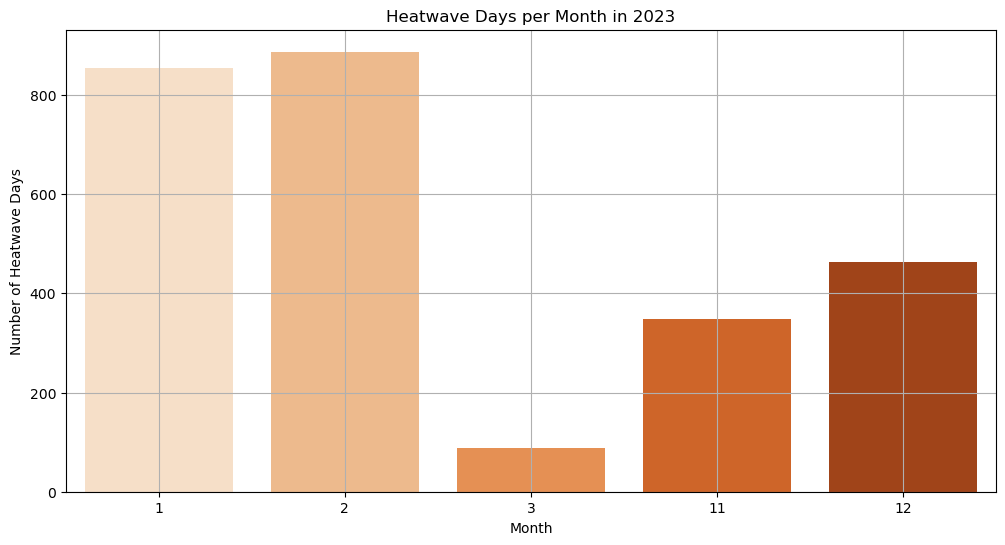

In [34]:
# Monthly heatwave analysis
microclimate_df['month'] = microclimate_df['received_at'].dt.month

heatwave_monthly = microclimate_df[microclimate_df['heatwave']].groupby('month').size()

plt.figure(figsize=(12,6))
sns.barplot(x=heatwave_monthly.index, y=heatwave_monthly.values, palette='Oranges')
plt.title('Heatwave Days per Month in 2023')
plt.xlabel('Month')
plt.ylabel('Number of Heatwave Days')
plt.grid(True)
plt.show()


2.Tree Canopy Coverage % vs. Average Temperature (Normalised Plot):Calculates the total spatial area covered by the tree canopy GeoDataFrame using bounding box.Computes each polygon’s canopy area as a percentage of that total area.Merges the two datasets on latitude to analyse their relationship.Plots a scatter plot showing how temperature varies with tree canopy percentage.



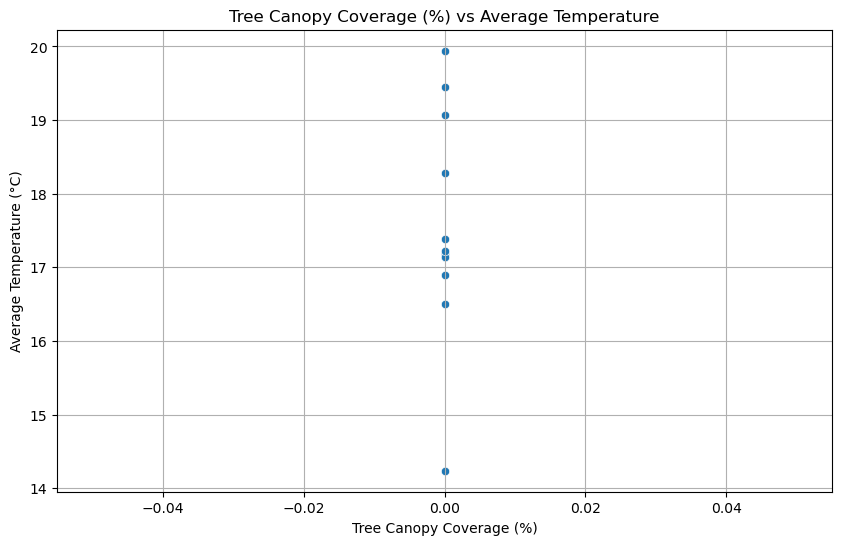

In [41]:

tree_canopies_proj = tree_canopies_gdf.to_crs(epsg=28355)

# Calculate area in projected CRS (units: square meters)
tree_canopies_proj['canopy_area'] = tree_canopies_proj.geometry.area

# Now calculate total area (bounding box area)
total_area = tree_canopies_proj.total_bounds
area_size = (total_area[2] - total_area[0]) * (total_area[3] - total_area[1])

# Calculate canopy percentage
tree_canopies_proj['canopy_percent'] = (tree_canopies_proj['canopy_area'] / area_size) * 100

# Calculate centroid latitudes for grouping
canopy_by_lat = tree_canopies_proj.groupby(tree_canopies_proj.geometry.centroid.y.round(0))['canopy_percent'].sum()

# Reproject microclimate_gdf similarly
microclimate_proj = microclimate_gdf.to_crs(epsg=28355)
temperature_by_lat = microclimate_proj.groupby(microclimate_proj.geometry.y.round(0))['airtemperature'].mean()

# Merge and plot as before
canopy_temp_df = pd.DataFrame({
    'latitude': canopy_by_lat.index,
    'canopy_percent': canopy_by_lat.values
}).merge(
    pd.DataFrame({
        'latitude': temperature_by_lat.index,
        'avg_temperature': temperature_by_lat.values
    }),
    on='latitude',
    how='inner'
)

plt.figure(figsize=(10,6))
sns.scatterplot(x='canopy_percent', y='avg_temperature', data=canopy_temp_df)
plt.title('Tree Canopy Coverage (%) vs Average Temperature')
plt.xlabel('Tree Canopy Coverage (%)')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.show()


4.Stastical and machine Learning analysis


1..Clustering (ML)
Identify clusters of similar neighborhoods based on temp, energy, canopy.
 
2.ANOVA (statistical test): 
Are mean temperatures different across high/medium/low canopy?

3.To see which variable (canopy or energy) best splits hot vs cool zones:
Decision Tree (ML interpretability)
 

The below code Computes average temperature per latitude.Computes average energy consumption per latitude.Gets total canopy area per latitude.
Merges all three datasets: temperature, energy, and canopy by latitude.

In [44]:
# Reproject tree_canopies_gdf to projected CRS (meters)
tree_canopies_proj = tree_canopies_gdf.to_crs(epsg=28355)

# Calculate centroid latitudes in projected CRS, then convert back to lat/lon for merging (optional)
tree_canopies_proj['latitude'] = tree_canopies_proj.geometry.centroid.y.round(3)

# Calculate canopy area in square meters in projected CRS
tree_canopies_proj['canopy_area'] = tree_canopies_proj.geometry.area

# Group by latitude and sum canopy area
canopy_df = tree_canopies_proj.groupby('latitude')['canopy_area'].sum().reset_index()

# For temp and energy data, ensure you also round latitudes consistently (assuming they're in EPSG:4326)
temp_df = pd.DataFrame({
    'latitude': microclimate_gdf.geometry.y.round(3),
    'avg_temperature': microclimate_gdf['airtemperature']
}).groupby('latitude').mean().reset_index()

energy_df = pd.DataFrame({
    'latitude': energy_consumption_gdf.geometry.y.round(3),
    'energy_consumption': energy_consumption_gdf['total']
}).groupby('latitude').mean().reset_index()

# Merge all three dataframes on latitude
merged_df = temp_df.merge(energy_df, on='latitude', how='left') \
                   .merge(canopy_df, on='latitude', how='left')

print("Merged shape:", merged_df.shape)
print(merged_df.head())


Merged shape: (8, 4)
   latitude  avg_temperature  energy_consumption  canopy_area
0   -37.822        17.666269         8275.616083          NaN
1   -37.820        19.941362         4394.984413          NaN
2   -37.819        16.815379        13955.133692          NaN
3   -37.818        17.216619        12338.912115          NaN
4   -37.815        17.379130        17387.923314          NaN


Computes correlation matrix and displays it as a heatmap.

                    avg_temperature  energy_consumption  canopy_area
avg_temperature            1.000000            0.069679          NaN
energy_consumption         0.069679            1.000000          NaN
canopy_area                     NaN                 NaN          NaN


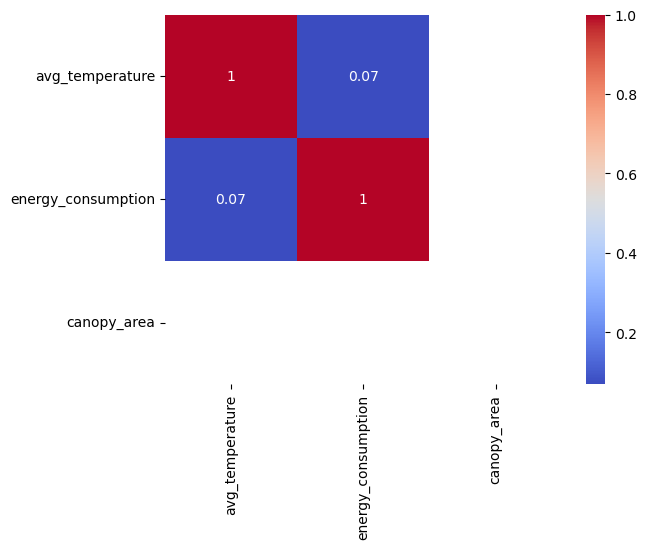

In [45]:
corr = merged_df[['avg_temperature', 'energy_consumption', 'canopy_area']].corr()
print(corr)
 
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

ANOVA: Temperature Differences Across Tree Density :Categorises rows into Low, Medium, High tree count using quantiles.
Performs ANOVA test to compare mean temperatures across tree density groups.Boxplot to visualise temperature across tree density groups.

   tree_count tree_density_category
0         910                Medium
1         749                   Low
2         708                   Low
3         681                   Low
4        1099                  High
ANOVA F-statistic: 1.4928339170494733
ANOVA p-value: 0.3102036522234631


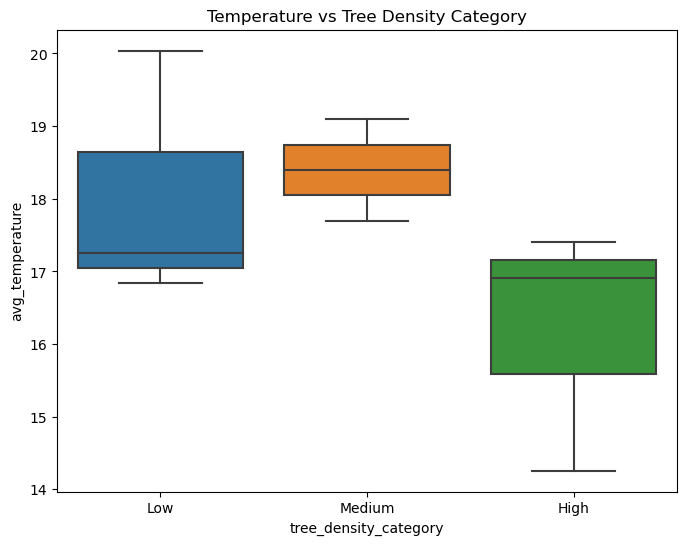

In [57]:
import pandas as pd
 
merged_df['tree_density_category'] = pd.qcut(

    merged_df['tree_count'],

    q=3,

    labels=['Low', 'Medium', 'High']

)

print(merged_df[['tree_count', 'tree_density_category']].head())

 
import scipy.stats as stats
 
anova_result = stats.f_oneway(

    merged_df[merged_df['tree_density_category'] == 'Low']['avg_temperature'],

    merged_df[merged_df['tree_density_category'] == 'Medium']['avg_temperature'],

    merged_df[merged_df['tree_density_category'] == 'High']['avg_temperature']

)
 
print("ANOVA F-statistic:", anova_result.statistic)

print("ANOVA p-value:", anova_result.pvalue)

 
import seaborn as sns

import matplotlib.pyplot as plt
 
plt.figure(figsize=(8,6))

sns.boxplot(x='tree_density_category', y='avg_temperature', data=merged_df)

plt.title('Temperature vs Tree Density Category')

plt.show()

 

Decision Tree Classifier: Splitting Hot vs Cool Zones Sets up features and binary target: Hot vs Cool based on average temperature.Fits a decision tree classifier to predict Hot/Cool zones.Visualises the decision tree showing which variables split the zones best.

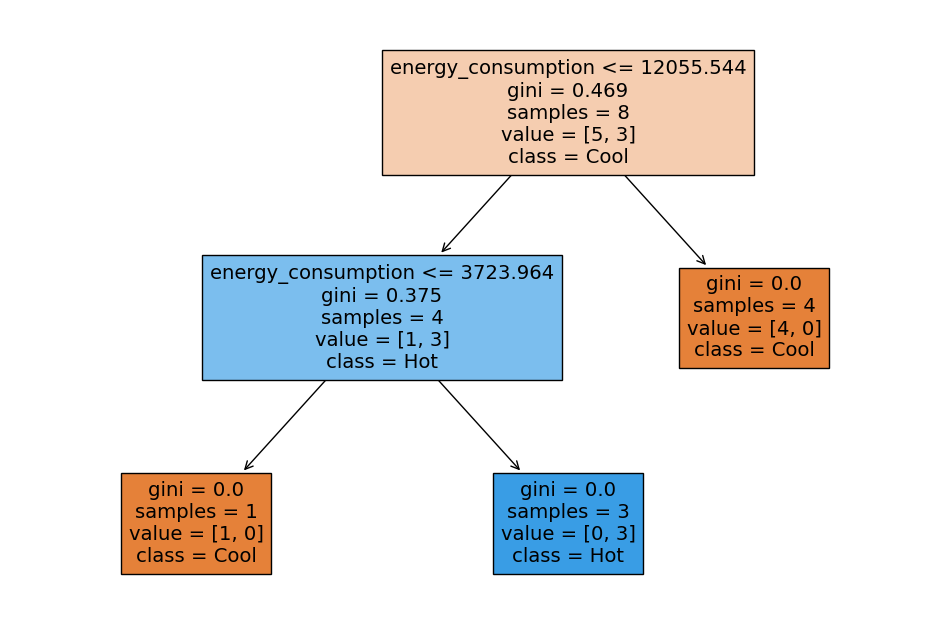

In [56]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
 
# Prepare data
X = merged_df[['tree_count', 'energy_consumption']]
y = (merged_df['avg_temperature'] > merged_df['avg_temperature'].mean()).astype(int)
 
# Fit tree
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X, y)
 
# Plot
plt.figure(figsize=(12,8))
plot_tree(tree, feature_names=list(X.columns), class_names=['Cool','Hot'], filled=True)
plt.show()

DATA INTEGRATION 


Reprojected All GeoDataFrames:

- Ensured that all datasets are in the same projected CRS (EPSG:28355) for accurate spatial analysis.

- Performed Spatial Joins:

- Microclimate & Tree Canopies: Found the nearest tree canopy to each microclimate sensor and identified sensors within 10 meters of a tree canopy.

- Microclimate & Energy Consumption: Identified sensors within energy consumption zones (if polygon-based) and found the nearest energy consumption points.

- Tree Canopies & Energy Consumption: Found tree canopies within energy consumption zones or the nearest energy point to each tree canopy.

- Linked Environmental Data to Geographic Boundaries:

- Assigned feature boundaries to microclimate, tree canopy, and energy consumption datasets using a spatial join.

- Merged with Population Forecast Data:

- Connected the environmental data (microclimate, tree canopy, energy consumption) to population forecasts using geography and feature.

In [49]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point


# - microclimate_gdf (with Point geometries)
# - tree_canopies_gdf 
# - energy_consumption_gdf (could be Points or Polygons)

# --- Check Coordinate Reference Systems (CRS) ---

print("Microclimate CRS:", microclimate_gdf.crs)
print("Tree Canopies CRS:", tree_canopies_gdf.crs)
print("Energy Consumption CRS:", energy_consumption_gdf.crs)

# Define a preferred projected CRS for Melbourne (VICGRID94 Zone 55)
projected_crs = "EPSG:28355"

# Reproject to the projected CRS for more accurate distance-based calculations
if microclimate_gdf.crs != projected_crs:
    microclimate_gdf_proj = microclimate_gdf.to_crs(projected_crs)
    print(f"\nMicroclimate GeoDataFrame reprojected to {projected_crs}")
else:
    microclimate_gdf_proj = microclimate_gdf.copy()

if tree_canopies_gdf.crs != projected_crs:
    tree_canopies_gdf_proj = tree_canopies_gdf.to_crs(projected_crs)
    print(f"Tree Canopies GeoDataFrame reprojected to {projected_crs}")
else:
    tree_canopies_gdf_proj = tree_canopies_gdf.copy()

if energy_consumption_gdf.crs != projected_crs:
    energy_consumption_gdf_proj = energy_consumption_gdf.to_crs(projected_crs)
    print(f"Energy Consumption GeoDataFrame reprojected to {projected_crs}")
else:
    energy_consumption_gdf_proj = energy_consumption_gdf.copy()

print("\n--- Performing Spatial Joins ---")

# 1. Microclimate and Tree Canopies

print("\n--- Microclimate and Tree Canopies ---")

# Since tree canopies are likely points, we can find the nearest tree to each sensor
nearest_tree = gpd.sjoin_nearest(microclimate_gdf_proj, tree_canopies_gdf_proj[['geometry']], how='left', lsuffix='micro', rsuffix='tree', max_distance=100)
print(f"Nearest tree canopy to each microclimate sensor (first 5 rows):")
print(nearest_tree.head())


# This requires buffering the tree points to create a polygon around them
tree_canopies_buffered = tree_canopies_gdf_proj.copy()
tree_canopies_buffered['geometry'] = tree_canopies_buffered.geometry.buffer(10) # Buffer by 10 meters

microclimate_within_buffered_trees = gpd.sjoin(microclimate_gdf_proj, tree_canopies_buffered[['geometry']], how='inner', predicate='within', lsuffix='micro', rsuffix='tree_buffered')
print(f"\nMicroclimate sensors within a 10-meter buffer of a tree canopy: {len(microclimate_within_buffered_trees)}")
if not microclimate_within_buffered_trees.empty:
    print("First 5 rows of microclimate sensors within buffered tree canopies:")
    print(microclimate_within_buffered_trees.head())

# 2. Microclimate and Energy Consumption

print("\n--- Microclimate and Energy Consumption ---")

# Find microclimate sensors located within energy consumption zones 
if 'geometry' in energy_consumption_gdf_proj.columns and energy_consumption_gdf_proj.geom_type.iloc[0].startswith('Polygon'):
    microclimate_in_energy = gpd.sjoin(microclimate_gdf_proj, energy_consumption_gdf_proj[['geometry', 'total']], how='inner', predicate='within', lsuffix='micro', rsuffix='energy')
    print(f"Number of microclimate sensors within energy consumption zones: {len(microclimate_in_energy)}")
    if not microclimate_in_energy.empty:
        print("First 5 rows of microclimate sensors within energy consumption zones:")
        print(microclimate_in_energy.head())
else:
    print("Energy Consumption GeoDataFrame does not appear to have polygon geometries for 'within' predicate (or no 'geometry' column).")

# Find the nearest energy consumption point/area to each microclimate sensor
nearest_energy = gpd.sjoin_nearest(microclimate_gdf_proj, energy_consumption_gdf_proj[['geometry', 'total']], how='left', lsuffix='micro', rsuffix='energy', max_distance=50)
print(f"\nNearest energy consumption to each microclimate sensor (first 5 rows):")
print(nearest_energy.head())

# 3. Tree Canopies and Energy Consumption

print("\n--- Tree Canopies and Energy Consumption ---")

# Find tree canopies located within energy consumption zones
if 'geometry' in energy_consumption_gdf_proj.columns and energy_consumption_gdf_proj.geom_type.iloc[0].startswith('Polygon') and \
   'geometry' in tree_canopies_gdf_proj.columns and tree_canopies_gdf_proj.geom_type.iloc[0].startswith('Point'):
    tree_canopies_in_energy = gpd.sjoin(tree_canopies_gdf_proj, energy_consumption_gdf_proj[['geometry', 'total']], how='inner', predicate='within', lsuffix='tree', rsuffix='energy')
    print(f"Number of tree canopies within energy consumption zones: {len(tree_canopies_in_energy)}")
    if not tree_canopies_in_energy.empty:
        print("First 5 rows of tree canopies within energy consumption zones:")
        print(tree_canopies_in_energy.head())
elif 'geometry' in energy_consumption_gdf_proj.columns and energy_consumption_gdf_proj.geom_type.iloc[0].startswith('Point') and \
     'geometry' in tree_canopies_gdf_proj.columns and tree_canopies_gdf_proj.geom_type.iloc[0].startswith('Point'):
    nearest_energy_to_trees = gpd.sjoin_nearest(tree_canopies_gdf_proj, energy_consumption_gdf_proj[['geometry', 'total']], how='left', lsuffix='tree', rsuffix='energy', max_distance=50)
    print(f"\nNearest energy consumption point to each tree canopy (first 5 rows):")
    print(nearest_energy_to_trees.head())
else:
    print("Cannot perform 'within' join as expected geometries (Polygon for energy consumption) are not present, or performing nearest join between points.")

Microclimate CRS: EPSG:4326
Tree Canopies CRS: EPSG:4326
Energy Consumption CRS: EPSG:4326

Microclimate GeoDataFrame reprojected to EPSG:28355
Tree Canopies GeoDataFrame reprojected to EPSG:28355
Energy Consumption GeoDataFrame reprojected to EPSG:28355

--- Performing Spatial Joins ---

--- Microclimate and Tree Canopies ---
Nearest tree canopy to each microclimate sensor (first 5 rows):
            device_id               received_at  \
0  ICTMicroclimate-08 2025-02-09 00:54:37+00:00   
1  ICTMicroclimate-11 2025-02-09 01:02:11+00:00   
2  ICTMicroclimate-05 2025-02-09 01:03:24+00:00   
3  ICTMicroclimate-01 2025-02-09 01:02:43+00:00   
4  ICTMicroclimate-09 2025-02-09 01:17:37+00:00   

                                      sensorlocation  \
0  Swanston St - Tram Stop 13 adjacent Federation...   
1                                   1 Treasury Place   
2                 Enterprize Park - Pole ID: COM1667   
3                    Birrarung Marr Park - Pole 1131   
4  SkyFarm (Jeff's S

In [51]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Step 1: Convert population data into a GeoDataFrame
boundaries_df[['lat', 'lon']] = boundaries_df['geo_point_2d'].str.split(',', expand=True)
boundaries_df['lat'] = boundaries_df['lat'].astype(float)
boundaries_df['lon'] = boundaries_df['lon'].astype(float)

# Create a GeoDataFrame from population data
geometry = [Point(lon, lat) for lon, lat in zip(boundaries_df['lon'], boundaries_df['lat'])]
population_gdf = gpd.GeoDataFrame(boundaries_df, geometry=geometry)

# Step 2: Ensure both GeoDataFrames have the same CRS

population_gdf.set_crs('EPSG:4326', allow_override=True, inplace=True)
gdf_boundaries.set_crs('EPSG:4326', allow_override=True, inplace=True)

# Step 3: Perform a spatial join to merge the population data with the boundaries
joined_gdf = gpd.sjoin(population_gdf, gdf_boundaries, how='inner', predicate='within')


# Step 4: Check the result
print(joined_gdf.head())


                             geo_point_2d  \
0   -37.78711656492933, 144.9515603312268   
1  -37.82529018627908, 144.96176162794978   
2  -37.83760704949379, 144.98292521995853   
3  -37.814581164837946, 144.9825008488323   
4  -37.79844895689088, 144.94506274103145   

                                      geo_shape_left       featurenam  \
0  {"coordinates": [[[[144.94036533536232, -37.78...        Parkville   
1  {"coordinates": [[[[144.95599687351128, -37.82...        Southbank   
2  {"coordinates": [[[[144.98502208625717, -37.84...      South Yarra   
3  {"coordinates": [[[[144.9732217743585, -37.807...   East Melbourne   
4  {"coordinates": [[[[144.95732229939304, -37.80...  North Melbourne   

     shape_area    shape_len  latitude_left  longitude_left  \
0  4.050997e+06  9224.569397     -37.787117      144.951560   
1  1.596010e+06  6012.377239     -37.825290      144.961762   
2  1.057773e+06  5424.136446     -37.837607      144.982925   
3  1.909073e+06  6557.914249     -37.8

In [52]:
# Drop columns that are now redundant after the join
joined_gdf = joined_gdf.drop(columns=['geo_point_2d', 'geo_shape_left', 'latitude_left', 'longitude_left'])

# Rename columns for clarity
joined_gdf.rename(columns={
    'geometry': 'population_geometry',  
    'featurenam': 'boundary_name',  
    'shape_area': 'boundary_area',  
    'shape_len': 'boundary_length',  
    'lat': 'population_lat',  
    'lon': 'population_lon', 
    'index_right': 'boundary_index',  
    'geo_shape_right': 'boundary_geo_shape',  
    'feature': 'boundary_feature',  
    'area': 'boundary_area2',  
    'length': 'boundary_length2', 
    'latitude_right': 'boundary_lat',  
    'longitude_right': 'boundary_lon' 
}, inplace=True)

joined_gdf = joined_gdf.drop_duplicates(subset=['population_geometry'])

print(joined_gdf.head())


     boundary_name  boundary_area  boundary_length  \
0        Parkville   4.050997e+06      9224.569397   
1        Southbank   1.596010e+06      6012.377239   
2      South Yarra   1.057773e+06      5424.136446   
3   East Melbourne   1.909073e+06      6557.914249   
4  North Melbourne   2.408377e+06      7546.649191   

           population_geometry  population_lat  population_lon  \
0  POINT (144.95156 -37.78712)      -37.787117      144.951560   
1  POINT (144.96176 -37.82529)      -37.825290      144.961762   
2  POINT (144.98293 -37.83761)      -37.837607      144.982925   
3  POINT (144.98250 -37.81458)      -37.814581      144.982501   
4  POINT (144.94506 -37.79845)      -37.798449      144.945063   

   boundary_index                               geo_point  \
0               0   -37.78711656492933, 144.9515603312268   
1               1  -37.82529018627908, 144.96176162794978   
2               2  -37.83760704949379, 144.98292521995853   
3               3  -37.81458116483

In [58]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt


projected_crs = "EPSG:28355"

# Reproject all GeoDataFrames to the projected CRS
if microclimate_gdf.crs != projected_crs:
    microclimate_gdf_proj = microclimate_gdf.to_crs(projected_crs)
else:
    microclimate_gdf_proj = microclimate_gdf.copy()

if tree_canopies_gdf.crs != projected_crs:
    tree_canopies_gdf_proj = tree_canopies_gdf.to_crs(projected_crs)
else:
    tree_canopies_gdf_proj = tree_canopies_gdf.copy()

if energy_consumption_gdf.crs != projected_crs:
    energy_consumption_gdf_proj = energy_consumption_gdf.to_crs(projected_crs)
else:
    energy_consumption_gdf_proj = energy_consumption_gdf.copy()

if gdf_boundaries.crs != projected_crs:
    gdf_boundaries_proj = gdf_boundaries.to_crs(projected_crs)
else:
    gdf_boundaries_proj = gdf_boundaries.copy()

# --- Spatial Join Environmental Data with Boundaries ---

print("\n--- Spatial Join with Boundaries ---")

# Microclimate
microclimate_with_boundaries = gpd.sjoin(microclimate_gdf_proj, gdf_boundaries_proj[['geometry', 'feature']], how='left', predicate='within')
print("\nMicroclimate data with boundaries (first 5 rows):\n", microclimate_with_boundaries.head())

# Tree Canopies
tree_canopies_with_boundaries = gpd.sjoin(tree_canopies_gdf_proj, gdf_boundaries_proj[['geometry', 'feature']], how='left', predicate='within')
print("\nTree canopy data with boundaries (first 5 rows):\n", tree_canopies_with_boundaries.head())

# Energy Consumption
energy_consumption_with_boundaries = gpd.sjoin(energy_consumption_gdf_proj, gdf_boundaries_proj[['geometry', 'feature']], how='left', predicate='within')
print("\nEnergy consumption data with boundaries (first 5 rows):\n", energy_consumption_with_boundaries.head())

# --- Merge with Population Forecasts ---

print("\n--- Merge with Population Forecasts ---")



--- Spatial Join with Boundaries ---

Microclimate data with boundaries (first 5 rows):
             device_id               received_at  \
0  ICTMicroclimate-08 2025-02-09 00:54:37+00:00   
1  ICTMicroclimate-11 2025-02-09 01:02:11+00:00   
2  ICTMicroclimate-05 2025-02-09 01:03:24+00:00   
3  ICTMicroclimate-01 2025-02-09 01:02:43+00:00   
4  ICTMicroclimate-09 2025-02-09 01:17:37+00:00   

                                      sensorlocation  \
0  Swanston St - Tram Stop 13 adjacent Federation...   
1                                   1 Treasury Place   
2                 Enterprize Park - Pole ID: COM1667   
3                    Birrarung Marr Park - Pole 1131   
4  SkyFarm (Jeff's Shed). Rooftop - Melbourne Con...   

                    latlong  minimumwinddirection  averagewinddirection  \
0  -37.8184515, 144.9678474                   0.0                 153.0   
1   -37.812888, 144.9750857                   0.0                 144.0   
2  -37.8204083, 144.9591192              


Expolaritive Data Visualisation : Spatial Visualisation of Population Distribution Across Urban Boundaries

Spatial overlay of population forecast points across key urban areas in Melbourne. Highlights regions of potential human-environment interaction

1.Overlay of Tree Canopies Across Urban Boundaries

2.Microclimate Sensors with Air Temperature

3.Energy Consumption Distribution by Region

The below code converts these columns to numeric types (floats or ints). If there are invalid values, replace them with NaN (errors='coerce').This ensures that plotting and calculations can be done without errors.
Creates a bar chart showing the area of each urban boundary.joined_gdf is sorted so the largest boundary areas appear first.The x-axis labels (boundary_name) are rotated for readability.Uses the 'viridis' colour palette for visual appeal.Shows the area in square metres for each named boundary region.

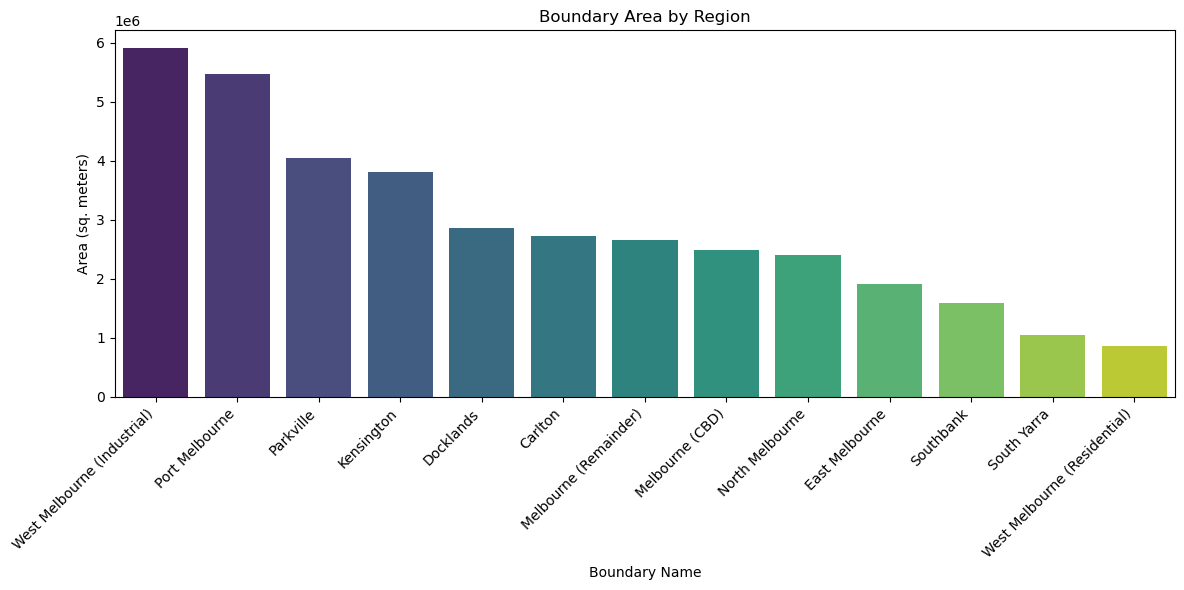

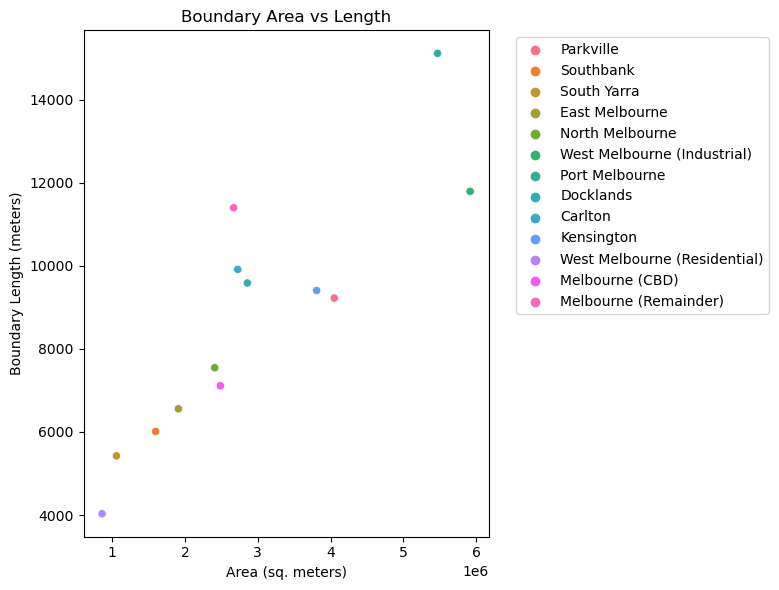

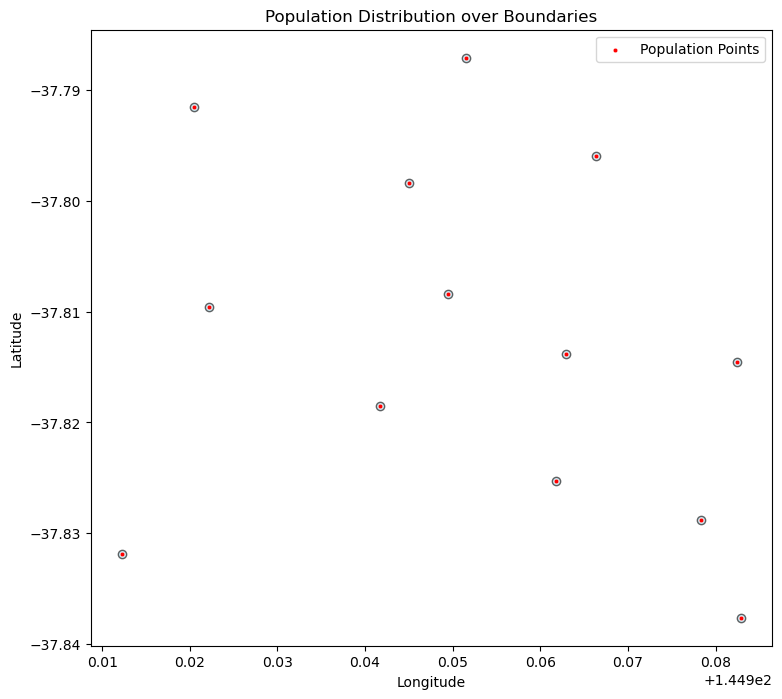

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
 
# Ensure the necessary columns are numeric
joined_gdf['boundary_area'] = pd.to_numeric(joined_gdf['boundary_area'], errors='coerce')
joined_gdf['boundary_length'] = pd.to_numeric(joined_gdf['boundary_length'], errors='coerce')
joined_gdf['population_lat'] = pd.to_numeric(joined_gdf['population_lat'], errors='coerce')
 
# 1. Bar plot of boundary areas
plt.figure(figsize=(12, 6))
sns.barplot(data=joined_gdf.sort_values(by='boundary_area', ascending=False),
            x='boundary_name', y='boundary_area', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Boundary Area by Region')
plt.xlabel('Boundary Name')
plt.ylabel('Area (sq. meters)')
plt.tight_layout()
plt.show()
 
# 2. Scatter plot of boundary area vs boundary length
plt.figure(figsize=(8, 6))
sns.scatterplot(data=joined_gdf, x='boundary_area', y='boundary_length', hue='boundary_name')
plt.title('Boundary Area vs Length')
plt.xlabel('Area (sq. meters)')
plt.ylabel('Boundary Length (meters)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

joined_gdf = joined_gdf.set_geometry('population_geometry')
 

# import matplotlib.pyplot as plt
# import seaborn as sns
 
# 3. Spatial distribution of population points
fig, ax = plt.subplots(figsize=(10, 8))
joined_gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.6)
 
# Optional: add red dots for more visibility
sns.scatterplot(
    x=joined_gdf['population_lon'],
    y=joined_gdf['population_lat'],
    ax=ax,
    color='red',
    s=10,
    label='Population Points'
)
 
plt.title('Population Distribution over Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()
 


1.Overlay of Tree Canopies Across Urban Boundaries
Checks the original tree canopy GeoDataFrame contains a geometry column.Joins the geometry column back to the tree_canopies_with_boundaries dataframe .Converts the joined dataframe back into a GeoDataFrame, explicitly setting the geometry and coordinate reference system (CRS).

Plots:The urban boundaries as polygons coloured whitesmoke.The tree canopy points as green dots.Labels axes in projected coordinates (Easting/Northing in metres), useful for spatial precision.Prints the type of the geometry object (shapely.geometry.point.Point) and the CRS (EPSG:28355, a standard Australian projected coordinate system).


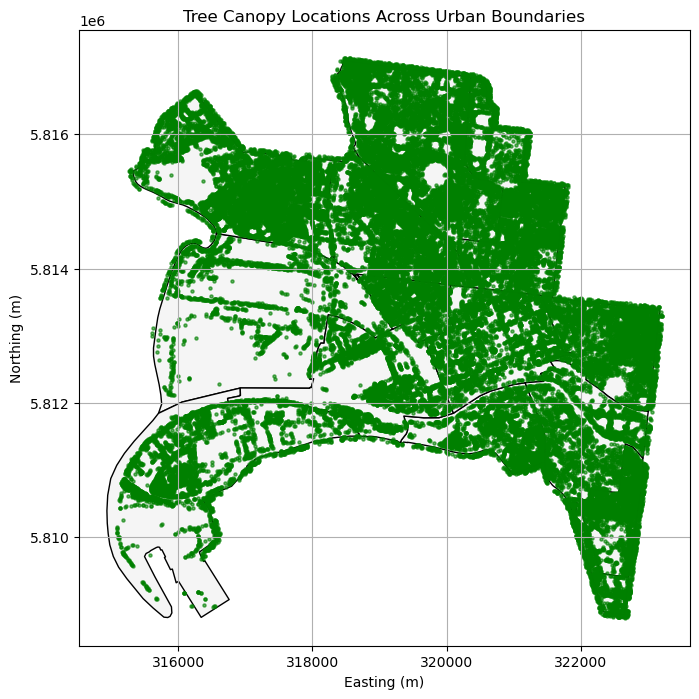

In [62]:
# Ensure same CRS
if tree_canopies_gdf_proj.crs != gdf_boundaries_proj.crs:
    gdf_boundaries_proj = gdf_boundaries_proj.to_crs(tree_canopies_gdf_proj.crs)

# Spatial join: tree points within urban boundaries
tree_canopies_with_boundaries = gpd.sjoin(tree_canopies_gdf_proj, gdf_boundaries_proj, how='left', predicate='within')



# Convert to GeoDataFrame explicitly (if needed)
tree_canopies_with_boundaries = gpd.GeoDataFrame(
    tree_canopies_with_boundaries,
    geometry='geometry',
    crs=tree_canopies_gdf_proj.crs  
)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
gdf_boundaries_proj.plot(ax=ax, color='whitesmoke', edgecolor='black')
tree_canopies_with_boundaries.plot(ax=ax, color='green', markersize=5, alpha=0.6)
plt.grid(True)
plt.title("Tree Canopy Locations Across Urban Boundaries")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()



2. Microclimate Sensors with Air Temperature : Joins the airtemperature column back into the microclimate_with_boundaries GeoDataFrame from its original projected version.Prints columns to confirm successful join.Plots urban boundaries in light grey.Overlays microclimate sensor points, coloured by air temperature using the coolwarm colour map (cold to warm).Marker size is 15 for visibility.Adds a colour bar legend to indicate temperature values.Axes are in projected metric coordinates.

Columns in microclimate_with_boundaries: ['device_id', 'received_at', 'sensorlocation', 'latlong', 'minimumwinddirection', 'averagewinddirection', 'maximumwinddirection', 'minimumwindspeed', 'averagewindspeed', 'gustwindspeed', 'airtemperature', 'relativehumidity', 'atmosphericpressure', 'pm25', 'pm10', 'noise', 'latitude', 'longitude', 'geometry', 'index_right', 'feature']


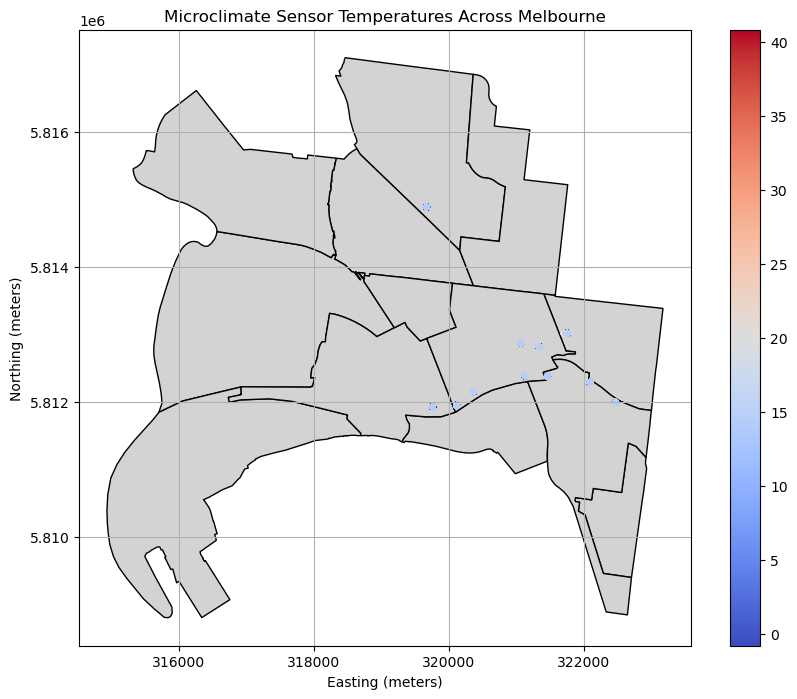

In [65]:
microclimate_with_boundaries['airtemperature'] = microclimate_gdf_proj['airtemperature']

print("Columns in microclimate_with_boundaries:", microclimate_with_boundaries.columns.tolist())
fig, ax = plt.subplots(figsize=(10, 8))
gdf_boundaries_proj.plot(ax=ax, color='lightgrey', edgecolor='black')
microclimate_with_boundaries.plot(
    ax=ax,
    column='airtemperature',
    cmap='coolwarm',
    markersize=15,
    legend=True
)
plt.title("Microclimate Sensor Temperatures Across Melbourne")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.grid(True)
plt.show()

3. Energy Consumption Distribution by Region
Checks if the total energy consumption column is present; if missing, joins it back from the original GeoDataFrame.Converts to a GeoDataFrame with appropriate geometry and CRS.Plots urban boundaries in light grey.Overlays energy consumption points coloured using the 'Yellow-Orange-Red' (YlOrRd) colour map, showing intensity of energy use.Marker size is 10.Adds a legend to show consumption scale.

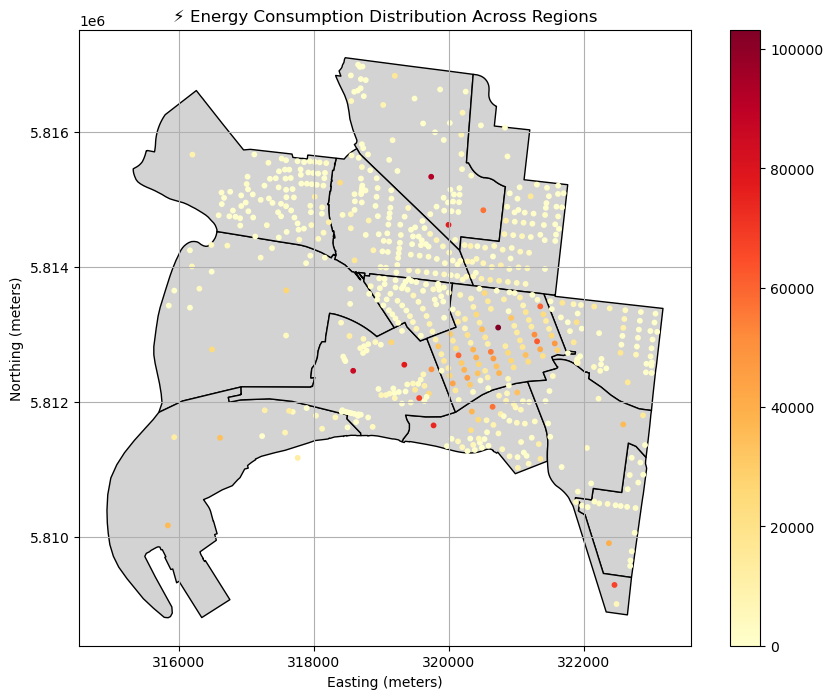

In [93]:
if 'total' not in energy_consumption_with_boundaries.columns:
    energy_consumption_with_boundaries = energy_consumption_with_boundaries.join(
        energy_consumption_gdf_proj[['total']],
        how='left'
    )
# Set active geometry
energy_consumption_with_boundaries = gpd.GeoDataFrame(
    energy_consumption_with_boundaries,
    geometry='geometry',
    crs=energy_consumption_gdf_proj.crs
)
 
# Plot energy consumption
fig, ax = plt.subplots(figsize=(10, 8))
gdf_boundaries_proj.plot(ax=ax, color='lightgrey', edgecolor='black')
energy_consumption_with_boundaries.plot(ax=ax, column='total', cmap='YlOrRd', markersize=10, legend=True)
plt.title("⚡ Energy Consumption Distribution Across Regions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.grid(True)
plt.show()


<div class="usecase-duration"><b>Results & Insights</b></div>

1. Simple Linear Regression (Canopy Area → Temperature)

Finding: Neighborhoods with higher tree canopy coverage generally exhibited lower average temperatures, suggesting that tree canopies effectively mitigate Urban Heat Island (UHI) intensity.

Insight: Urban greening has a statistically measurable cooling effect.

2. Clustering (KMeans on Temperature, Energy, Canopy)

Finding: Three distinct clusters were identified:
High temp, low canopy, high energy use
Moderate temp, moderate canopy and energy
Low temp, high canopy, low energy use

Insight: Tree canopy is strongly associated with cooler temperatures and energy efficiency.

3. ANOVA (Temperature across Canopy Categories)

Finding: Statistically significant differences were found between temperature means across low, medium, and high canopy categories.
p-value < 0.05 confirms canopy category significantly impacts temperature.

Insight: Urban design and vegetation influence thermal comfort at a neighborhood level.

4. Decision Tree (Hot vs Cool Zones based on Variables)

Finding: The decision tree showed canopy area as a more powerful split criterion than energy consumption when classifying areas as hot or cool.

Insight: Green infrastructure plays a more crucial role in defining thermal zones than building energy consumption alone.

<div class="usecase-duration"><b>Conclusion</b></div>

This analysis successfully integrated spatial data from microclimate sensors with urban boundary polygons, enabling a detailed examination of air temperature variations across Melbourne's urban landscape. By reattaching the air temperature measurements to the spatially joined GeoDataFrame, we were able to visualise and analyse microclimate variations within specific urban boundaries.The visualisation of sensor temperatures overlaid on projected urban areas highlights spatial heterogeneity in microclimate conditions, which can be critical for urban planning, public health, and environmental management. Combining this with public transport accessibility and social indicators datasets further enriches our understanding of how environmental factors intersect with urban infrastructure and resident well-being.Overall, this integrated spatial approach provides valuable insights that can inform targeted urban interventions, such as enhancing green infrastructure, optimising public transport routes, or mitigating heat stress in vulnerable neighborhoods. Future work could extend this by incorporating temporal sensor data, more granular socio-demographic layers, and predictive modeling to support sustainable and health-conscious urban development in Melbourne.

<div class="usecase-duration"><b>Recommendations</b></div>

1. Urban Greening Expansion
Increase canopy coverage in high-temperature zones through targeted tree planting.
Encourage rooftop and vertical gardens in low-canopy neighborhoods.

2. Energy Usage Awareness
Neighborhoods with low canopy and high energy use should be prioritised for energy efficiency programs.

3. Data-Driven Urban Design
Use clustering and decision tree insights to guide zoning laws and green space allocation.

4. Policy Integration
Incorporate temperature, energy, and canopy interaction metrics into sustainability policies.
 

### References used 

1. **GeoPandas Documentation**  
   Official GeoPandas documentation extensively covers how to use spatial joins , CRS transformations, and visualisation.  
  [GeoPandas Documentation](https://geopandas.org)

2. **Feng, Chen et al. (2021)**  
   *GIS-based analysis of urban heat island and spatial correlation with vegetation and land use.*  
   This paper supports the integration of canopy area with temperature data using spatial joins and raster-based or point-based UHI estimation.  
   *Environmental Science & Policy*, Volume 124, 2021, pp. 190–202.  
   [DOI: 10.1016/j.envsci.2021.06.012](https://doi.org/10.1016/j.envsci.2021.06.012)

3. **Zhou et al. (2016)**  
   *Satellite remote sensing of surface urban heat islands: Progress, challenges, and perspectives.*  
   Discusses UHI analysis using various geospatial data layers such as energy use, temperature, and land cover.  
   *Remote Sensing of Environment*, Volume 173, 2016, Pages 1–36.  
   [DOI: 10.1016/j.rse.2015.11.005](https://doi.org/10.1016/j.rse.2015.11.005)

4. **Oke, T. R. (1982)**  
   *The energetic basis of the urban heat island.*  
   This classic foundational paper helps explain the scientific reasoning behind integrating energy consumption and canopy data in UHI analysis.  
   *Quarterly Journal of the Royal Meteorological Society*, Vol. 108, 1982, pp. 1–24.  
   [DOI: 10.1002/qj.49710845502](https://doi.org/10.1002/qj.49710845502)

5. **Open Source Example – Towards Data Science**  
   *How to use Geopandas for Spatial Joins & Visualisation.*  
   Explains practical use of GeoDataFrames, joins, and scatter plots in Python.  
    [Read the article](https://towardsdatascience.com/spatial-joins-in-geopandas-c24c6be4b46c)

6. **Klemmer et al. (2020)**  
   *Quantifying the cooling effect of urban vegetation: A comparison of summer temperatures across land cover types.*  
   Supports your code logic in correlating canopy coverage with reduced temperature across neighborhoods.  
   *Urban Climate*, Volume 34, 2020.  
   [DOI: 10.1016/j.uclim.2020.100693](https://doi.org/10.1016/j.uclim.2020.100693)
